# Modeling for hourly data

In [1]:
# libs
# system
from datetime import datetime
import math
import random

# data prep
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# model
import lightgbm as lgb
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
xlsx_df = pd.read_excel('AirQualityUCI/AirQualityUCI.xlsx', sep=';')
xlsx_df.head(2)

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   

      T         RH        AH  
0  13.6  48.875001  0.757754  
1  13.3  47.700000  0.725487

Are there any NaN value:  False


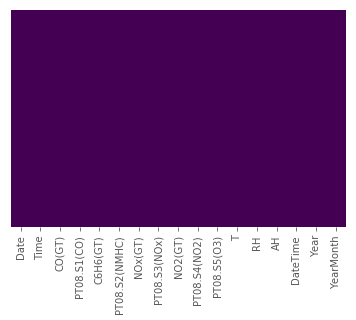

In [3]:
xlsx_df.replace(to_replace= -200, value= np.NaN, inplace= True)

xlsx_df.drop(['NMHC(GT)'], axis= 1, inplace= True)
# date
xlsx_df['DateTime'] = xlsx_df['Date'].astype(str) + ' ' + xlsx_df['Time'].astype(str)
xlsx_df['DateTime'] = pd.to_datetime(xlsx_df['DateTime'], format='%Y-%m-%d %H:%M:%S')

xlsx_df['Date'] = pd.to_datetime(xlsx_df['Date'].astype(str), format='%Y-%m-%d')

# for year trend visualization perpose, this helps
xlsx_df['Year'] = xlsx_df['DateTime'].map(lambda x: x.year)

xlsx_df['YearMonth'] = pd.to_datetime(xlsx_df.DateTime).dt.to_period('m')

# fill NaN
interpolateList = [x for x in xlsx_df.columns if x not in ['Date', 'Time', 'DateTime', 'Year', 'YearMonth']]

# interpolatoin 
for col in interpolateList:
    xlsx_df[col].interpolate(method='linear', inplace=True)
    
print('Are there any NaN value: ', xlsx_df.isnull().values.any())
# show missing value again
sns.heatmap(xlsx_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### feature selection
* minimum feature(s): select `C6H6`, `NOx` and `NO2` at first, because `T`, `RH`, `AH` show very low correlation (almost `0`) with label `CO`. In this way, one can lower the possibility of overfitting.

In [4]:
featureList = ["DateTime", "YearMonth", "CO(GT)", "C6H6(GT)", "NOx(GT)", "PT08.S5(O3)"]

df = xlsx_df[featureList].copy() # copy())prevent SettingwithCopyWarning
df.rename(columns={"CO(GT)": "CO", "C6H6(GT)": "C6H6", "NOx(GT)": "NOx"}, inplace=True) # rename column by passing a dict
print('after get daily mean, dataframe shape: ', df.shape)
df.head(2)

after get daily mean, dataframe shape:  (9357, 6)


DateTime YearMonth   CO       C6H6    NOx  PT08.S5(O3)
0 2004-03-10 18:00:00   2004-03  2.6  11.881723  166.0      1267.50
1 2004-03-10 19:00:00   2004-03  2.0   9.397165  103.0       972.25

#### shift n days for regression model
In this mission, it is required to shift `n = 5` days

In [5]:
numWePredict = 5 # number of days that we want to predict

In [6]:
shift_col_name = "NO2(GT)" # choose the chemical you want

In [41]:
futureYList = []
# generate sequence (label y)
for n in range(1, numWePredict+1):
    colStr = shift_col_name + "(+" + str(n) + ")"
    df[colStr] = xlsx_df[shift_col_name].shift(-n)
    futureYList.append(colStr)
df.dropna(inplace=True) # drop last n(n = numWePredict) rows with NaN
print('futureYList we want to track: ', futureYList)
df.tail(5)

futureYList we want to track:  ['NO2(GT)(+1)', 'NO2(GT)(+2)', 'NO2(GT)(+3)', 'NO2(GT)(+4)', 'NO2(GT)(+5)']


DateTime YearMonth   CO       C6H6    NOx  PT08.S5(O3)  \
9347 2005-04-04 05:00:00   2005-04  0.5   1.307608   76.5       577.50   
9348 2005-04-04 06:00:00   2005-04  1.1   4.359341  182.2       905.00   
9349 2005-04-04 07:00:00   2005-04  4.0  17.364240  593.7      1457.25   
9350 2005-04-04 08:00:00   2005-04  5.0  22.393233  586.2      1704.50   
9351 2005-04-04 09:00:00   2005-04  3.9  13.552393  522.7      1582.50   

      NO2(GT)(+1)  NO2(GT)(+2)  NO2(GT)(+3)  NO2(GT)(+4)  NO2(GT)(+5)  
9347         93.0        154.6        173.6        186.5        189.8  
9348        154.6        173.6        186.5        189.8        179.2  
9349        173.6        186.5        189.8        179.2        174.7  
9350        186.5        189.8        179.2        174.7        155.7  
9351        189.8        179.2        174.7        155.7        167.7

### Modeling
* LGBM
    * multi-variate regression model
* RNN

#### trains models
* use data range from 2004/03 ~ 2004/12

In [8]:
df_X = df[[x for x in df.columns if x not in futureYList]]
df_y = df[futureYList] # n (n = numWePredict) labels
print('df_X: \n', df_X.head(2))
print('\n')
print('df_y: \n', df_y.head(2))
print('\n')
print('futureYList: ', futureYList)

df_X: 
              DateTime YearMonth   CO       C6H6    NOx  PT08.S5(O3)
0 2004-03-10 18:00:00   2004-03  2.6  11.881723  166.0      1267.50
1 2004-03-10 19:00:00   2004-03  2.0   9.397165  103.0       972.25


df_y: 
    NO2(GT)(+1)  NO2(GT)(+2)  NO2(GT)(+3)  NO2(GT)(+4)  NO2(GT)(+5)
0         92.0        114.0        122.0        116.0         96.0
1        114.0        122.0        116.0         96.0         77.0


futureYList:  ['NO2(GT)(+1)', 'NO2(GT)(+2)', 'NO2(GT)(+3)', 'NO2(GT)(+4)', 'NO2(GT)(+5)']


In [9]:
year2004PeriodArray = [x for x in df_X.YearMonth.unique() if x.year == 2004 ]
print(year2004PeriodArray)
X_train = df_X.loc[df_X.YearMonth.isin(year2004PeriodArray)].copy()
y_train = df_y.loc[df_X.YearMonth.isin(year2004PeriodArray)].copy()
print('\n')
print('X_train: \n', X_train.head(2))
print('\n')
print('y_train: \n', y_train.head(2))

[Period('2004-03', 'M'), Period('2004-04', 'M'), Period('2004-05', 'M'), Period('2004-06', 'M'), Period('2004-07', 'M'), Period('2004-08', 'M'), Period('2004-09', 'M'), Period('2004-10', 'M'), Period('2004-11', 'M'), Period('2004-12', 'M')]


X_train: 
              DateTime YearMonth   CO       C6H6    NOx  PT08.S5(O3)
0 2004-03-10 18:00:00   2004-03  2.6  11.881723  166.0      1267.50
1 2004-03-10 19:00:00   2004-03  2.0   9.397165  103.0       972.25


y_train: 
    NO2(GT)(+1)  NO2(GT)(+2)  NO2(GT)(+3)  NO2(GT)(+4)  NO2(GT)(+5)
0         92.0        114.0        122.0        116.0         96.0
1        114.0        122.0        116.0         96.0         77.0


#### validates models
* use data range from 2005/01 ~ 2005/04

In [10]:
year2005PeriodArray = [x for x in df_X.YearMonth.unique() if x.year == 2005 ]
print(year2005PeriodArray)

X_valid = df_X.loc[df_X.YearMonth.isin(year2005PeriodArray)].copy()
y_valid = df_y.loc[df_X.YearMonth.isin(year2005PeriodArray)].copy()
X_valid.reset_index(inplace=True)
y_valid.reset_index(inplace=True)
X_valid.drop(columns=['index'], inplace=True)
y_valid.drop(columns=['index'], inplace=True)

print('X_valid shape: ', X_valid.shape)
print('y_valid shape: ', y_valid.shape)
print('\n')
print('X_valid: \n', X_valid.head(2))
print('\n')
print('y_valid: \n', y_valid.head(2))

[Period('2005-01', 'M'), Period('2005-02', 'M'), Period('2005-03', 'M'), Period('2005-04', 'M')]
X_valid shape:  (2242, 6)
y_valid shape:  (2242, 5)


X_valid: 
              DateTime YearMonth        CO      C6H6         NOx  PT08.S5(O3)
0 2005-01-01 00:00:00   2005-01  1.595876  4.247511  214.385567      1201.25
1 2005-01-01 01:00:00   2005-01  1.600000  8.763027  214.900000      1617.00


y_valid: 
    NO2(GT)(+1)  NO2(GT)(+2)  NO2(GT)(+3)  NO2(GT)(+4)  NO2(GT)(+5)
0        106.3        128.6        127.3        126.0        105.7
1        128.6        127.3        126.0        105.7         99.0


### Normalization
* features normalization: change solution space into a uniform shape

In [11]:
# training / testing set
normColList = [x for x in X_train.columns if x not in ["DateTime", "YearMonth"]]
min_max_scaler = MinMaxScaler() # default range: (0, 1)
X_train_norm = pd.DataFrame(min_max_scaler.fit_transform(X_train[normColList].values), columns=normColList) # feed in a numpy array
# concat dfs
X_train_norm = pd.concat( [X_train[["YearMonth"]], X_train_norm], axis=1)
X_train_norm.head(2)

YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469

In [12]:
# validation set
min_max_scaler = MinMaxScaler() # call MinMaxScaler object
X_valid_norm = pd.DataFrame(min_max_scaler.fit_transform(X_valid[normColList].values), columns=normColList) # feed in a numpy array
# concat dfs
X_valid_norm = pd.concat( [X_valid[["YearMonth"]], X_valid_norm], axis=1)
X_valid_norm.head(2)

YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.173939  0.095741  0.162572     0.431353
1   2005-01  0.174419  0.201225  0.162996     0.614301

#### Hyperparameter Tuning

In [13]:
# basic hyperparameters for linear regression
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

Starting training...
startYearMonth:  2004-03
X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0     92.0
1    114.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    23.0
1975    26.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l1: 31.6507	valid_0's l2: 1498.98
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 31.4233	valid_0's l2: 1479.33
[3]	valid_0's l1: 31.1962	valid_0's l2: 1459.84
[4]	valid_0's l1: 31.0213	valid_0's l2: 1444.49
[5]	valid_0's l1: 30.8036	valid_0's l2: 1425.93
[6]	valid_0's l1: 30.6052	valid_0's l2: 1409.21
[7]	valid_0's l1: 30.4097	valid_0's l2: 1392.87
[8]	valid_0's l1: 30.194	v

[171]	valid_0's l1: 17.4672	valid_0's l2: 533.488
[172]	valid_0's l1: 17.4463	valid_0's l2: 532.562
[173]	valid_0's l1: 17.4251	valid_0's l2: 531.635
[174]	valid_0's l1: 17.4048	valid_0's l2: 530.727
[175]	valid_0's l1: 17.3866	valid_0's l2: 529.713
[176]	valid_0's l1: 17.3691	valid_0's l2: 528.876
[177]	valid_0's l1: 17.3529	valid_0's l2: 528.073
[178]	valid_0's l1: 17.3363	valid_0's l2: 527.348
[179]	valid_0's l1: 17.3207	valid_0's l2: 526.503
[180]	valid_0's l1: 17.3052	valid_0's l2: 525.668
[181]	valid_0's l1: 17.2839	valid_0's l2: 524.672
[182]	valid_0's l1: 17.2629	valid_0's l2: 523.722
[183]	valid_0's l1: 17.2433	valid_0's l2: 522.816
[184]	valid_0's l1: 17.2301	valid_0's l2: 522.063
[185]	valid_0's l1: 17.2171	valid_0's l2: 521.328
[186]	valid_0's l1: 17.1969	valid_0's l2: 520.582
[187]	valid_0's l1: 17.1797	valid_0's l2: 519.806
[188]	valid_0's l1: 17.1666	valid_0's l2: 519.333
[189]	valid_0's l1: 17.1542	valid_0's l2: 518.659
[190]	valid_0's l1: 17.1342	valid_0's l2: 517.872


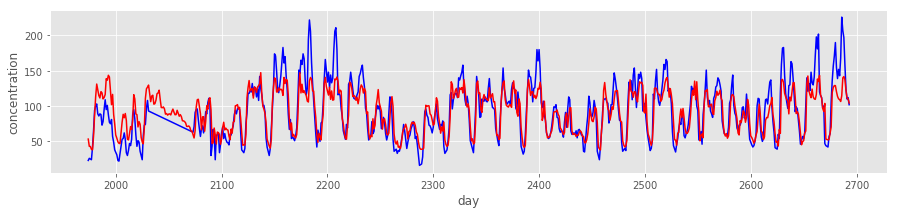

X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    114.0
1    122.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    26.0
1975    25.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l1: 31.6345	valid_0's l2: 1497.83
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 31.4722	valid_0's l2: 1483.94
[3]	valid_0's l1: 31.315	valid_0's l2: 1470.31
[4]	valid_0's l1: 31.199	valid_0's l2: 1460.07
[5]	valid_0's l1: 31.0441	valid_0's l2: 1446.95
[6]	valid_0's l1: 30.9046	valid_0's l2: 1435.21
[7]	valid_0's l1: 30.7707	valid_0's l2: 1423.91
[8]	valid_0's l1: 30.6303	valid_0's l2: 1411.76
[9]	valid_0's l1: 30.4898	

[262]	valid_0's l1: 22.1529	valid_0's l2: 796.504
[263]	valid_0's l1: 22.1492	valid_0's l2: 796.296
[264]	valid_0's l1: 22.1483	valid_0's l2: 796.184
[265]	valid_0's l1: 22.1447	valid_0's l2: 796.051
[266]	valid_0's l1: 22.1396	valid_0's l2: 795.803
[267]	valid_0's l1: 22.1345	valid_0's l2: 795.564
[268]	valid_0's l1: 22.1291	valid_0's l2: 795.297
[269]	valid_0's l1: 22.1302	valid_0's l2: 795.432
[270]	valid_0's l1: 22.1295	valid_0's l2: 795.426
[271]	valid_0's l1: 22.1248	valid_0's l2: 795.243
[272]	valid_0's l1: 22.1244	valid_0's l2: 795.178
[273]	valid_0's l1: 22.1234	valid_0's l2: 795.096
[274]	valid_0's l1: 22.1267	valid_0's l2: 795.092
[275]	valid_0's l1: 22.1301	valid_0's l2: 795.094
[276]	valid_0's l1: 22.1327	valid_0's l2: 795.207
[277]	valid_0's l1: 22.1311	valid_0's l2: 795.114
[278]	valid_0's l1: 22.1344	valid_0's l2: 795.249
Early stopping, best iteration is:
[273]	valid_0's l1: 22.1234	valid_0's l2: 795.096
The rmse of prediction is: 28.197451278546904

Saving model 1...


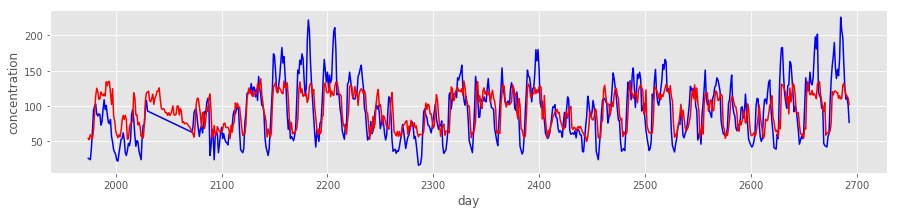

X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    122.0
1    116.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    25.0
1975    24.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l1: 31.6445	valid_0's l2: 1498.36
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 31.5386	valid_0's l2: 1489.35
[3]	valid_0's l1: 31.4329	valid_0's l2: 1480.5
[4]	valid_0's l1: 31.3518	valid_0's l2: 1473.26
[5]	valid_0's l1: 31.2526	valid_0's l2: 1464.77
[6]	valid_0's l1: 31.1729	valid_0's l2: 1458.27
[7]	valid_0's l1: 31.093	valid_0's l2: 1451.64
[8]	valid_0's l1: 30.9955	valid_0's l2: 1443.71
[9]	valid_0's l1: 30.9053	

[162]	valid_0's l1: 26.0512	valid_0's l2: 1066.57
[163]	valid_0's l1: 26.0429	valid_0's l2: 1066.09
[164]	valid_0's l1: 26.0377	valid_0's l2: 1065.86
[165]	valid_0's l1: 26.0326	valid_0's l2: 1065.65
[166]	valid_0's l1: 26.0172	valid_0's l2: 1064.93
[167]	valid_0's l1: 26.002	valid_0's l2: 1064.2
[168]	valid_0's l1: 25.9874	valid_0's l2: 1063.52
[169]	valid_0's l1: 25.978	valid_0's l2: 1063.15
[170]	valid_0's l1: 25.9712	valid_0's l2: 1062.88
[171]	valid_0's l1: 25.9606	valid_0's l2: 1062.32
[172]	valid_0's l1: 25.9605	valid_0's l2: 1062.36
[173]	valid_0's l1: 25.955	valid_0's l2: 1062.04
[174]	valid_0's l1: 25.9508	valid_0's l2: 1061.75
[175]	valid_0's l1: 25.9474	valid_0's l2: 1061.38
[176]	valid_0's l1: 25.9375	valid_0's l2: 1060.74
[177]	valid_0's l1: 25.9315	valid_0's l2: 1060.39
[178]	valid_0's l1: 25.9246	valid_0's l2: 1059.98
[179]	valid_0's l1: 25.9214	valid_0's l2: 1059.8
[180]	valid_0's l1: 25.9185	valid_0's l2: 1059.62
[181]	valid_0's l1: 25.9143	valid_0's l2: 1059.52
[182]

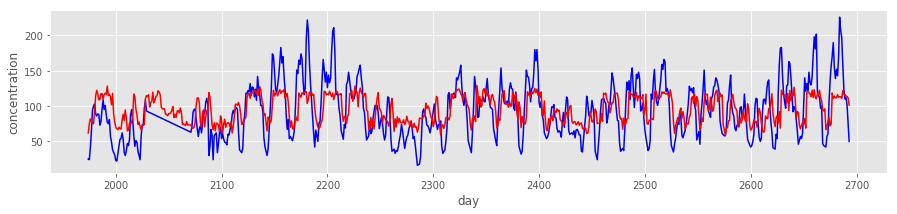

X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    116.0
1     96.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    24.0
1975    41.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l1: 31.6462	valid_0's l2: 1497.7
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 31.5747	valid_0's l2: 1491.64
[3]	valid_0's l1: 31.505	valid_0's l2: 1485.61
[4]	valid_0's l1: 31.4551	valid_0's l2: 1480.84
[5]	valid_0's l1: 31.3867	valid_0's l2: 1475.11
[6]	valid_0's l1: 31.3331	valid_0's l2: 1470.83
[7]	valid_0's l1: 31.2802	valid_0's l2: 1466.66
[8]	valid_0's l1: 31.2113	valid_0's l2: 1460.86
[9]	valid_0's l1: 31.1425	

The rmse of prediction is: 34.39058602964879

Saving model 3...
------------------------------------------------------


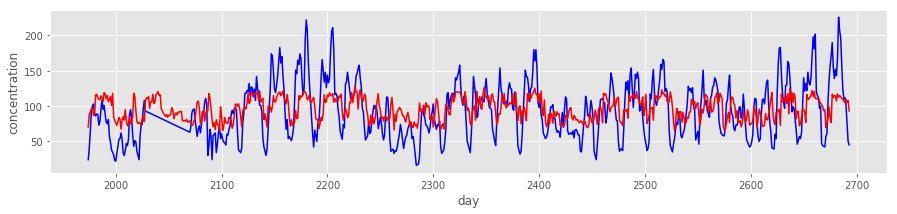

X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    96.0
1    77.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    41.0
1975    65.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l1: 31.6356	valid_0's l2: 1495.54
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 31.5812	valid_0's l2: 1490.92
[3]	valid_0's l1: 31.5278	valid_0's l2: 1486.16
[4]	valid_0's l1: 31.4913	valid_0's l2: 1481.86
[5]	valid_0's l1: 31.44	valid_0's l2: 1477.57
[6]	valid_0's l1: 31.3958	valid_0's l2: 1473.54
[7]	valid_0's l1: 31.3521	valid_0's l2: 1469.6
[8]	valid_0's l1: 31.31	valid_0's l2: 1466.15
[9]	valid_0's l1: 31.2574	valid

The rmse of prediction is: 35.069920588307696

Saving model 4...
------------------------------------------------------


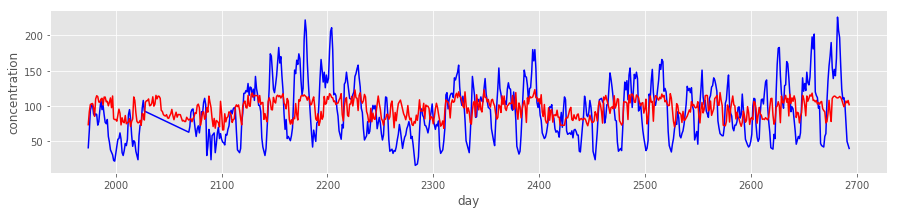

startYearMonth:  2004-04
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    70.0
511    55.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    77.0
2695    50.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l1: 33.901	valid_0's l2: 1721.86
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 33.6921	valid_0's l2: 1702.32
[3]	valid_0's l1: 33.4903	valid_0's l2: 1683.55
[4]	valid_0's l1: 33.346	valid_0's l2: 1669.4
[5]	valid_0's l1: 33.1425	valid_0's l2: 1650.75
[6]	valid_0's l1: 32.9534	valid_0's l2: 1634.1
[7]	valid_0's l1: 32.7667	valid_0's l2: 1617.76
[8]	valid_0's l1: 32.5689	valid_0's l2: 

[185]	valid_0's l1: 20.2295	valid_0's l2: 699.963
[186]	valid_0's l1: 20.2118	valid_0's l2: 698.902
[187]	valid_0's l1: 20.194	valid_0's l2: 697.878
[188]	valid_0's l1: 20.1728	valid_0's l2: 696.751
[189]	valid_0's l1: 20.1646	valid_0's l2: 696.215
[190]	valid_0's l1: 20.148	valid_0's l2: 695.239
[191]	valid_0's l1: 20.1315	valid_0's l2: 694.272
[192]	valid_0's l1: 20.1171	valid_0's l2: 693.525
[193]	valid_0's l1: 20.1067	valid_0's l2: 692.891
[194]	valid_0's l1: 20.0929	valid_0's l2: 692.167
[195]	valid_0's l1: 20.0787	valid_0's l2: 691.461
[196]	valid_0's l1: 20.0605	valid_0's l2: 690.388
[197]	valid_0's l1: 20.0424	valid_0's l2: 689.383
[198]	valid_0's l1: 20.0212	valid_0's l2: 688.178
[199]	valid_0's l1: 20.0022	valid_0's l2: 687.072
[200]	valid_0's l1: 19.9848	valid_0's l2: 686.098
[201]	valid_0's l1: 19.972	valid_0's l2: 685.281
[202]	valid_0's l1: 19.9587	valid_0's l2: 684.453
[203]	valid_0's l1: 19.9446	valid_0's l2: 683.64
[204]	valid_0's l1: 19.9322	valid_0's l2: 682.866
[205

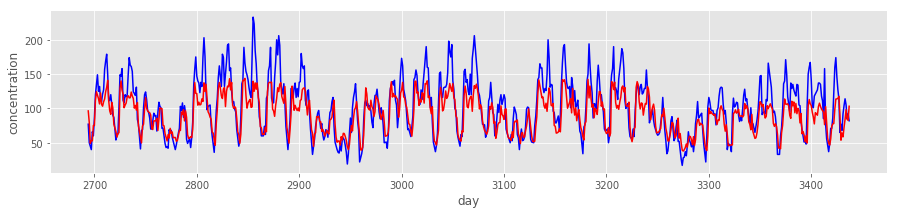

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    55.0
511    52.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    50.0
2695    45.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l1: 33.9714	valid_0's l2: 1728.13
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 33.8161	valid_0's l2: 1714.07
[3]	valid_0's l1: 33.6712	valid_0's l2: 1700.91
[4]	valid_0's l1: 33.5743	valid_0's l2: 1691.13
[5]	valid_0's l1: 33.4234	valid_0's l2: 1677.73
[6]	valid_0's l1: 33.2862	valid_0's l2: 1665.84
[7]	valid_0's l1: 33.1525	valid_0's l2: 1654.18
[8]	valid_0's l1: 33.0095	valid_0's l2: 1641.53
[9]	valid_0's

[196]	valid_0's l1: 24.4645	valid_0's l2: 973.42
[197]	valid_0's l1: 24.4525	valid_0's l2: 972.585
[198]	valid_0's l1: 24.4463	valid_0's l2: 972.059
[199]	valid_0's l1: 24.4342	valid_0's l2: 971.146
[200]	valid_0's l1: 24.4225	valid_0's l2: 970.256
[201]	valid_0's l1: 24.4124	valid_0's l2: 969.611
[202]	valid_0's l1: 24.4021	valid_0's l2: 968.981
[203]	valid_0's l1: 24.3937	valid_0's l2: 968.443
[204]	valid_0's l1: 24.3833	valid_0's l2: 967.828
[205]	valid_0's l1: 24.3756	valid_0's l2: 967.407
[206]	valid_0's l1: 24.3636	valid_0's l2: 966.524
[207]	valid_0's l1: 24.3521	valid_0's l2: 965.64
[208]	valid_0's l1: 24.3391	valid_0's l2: 964.661
[209]	valid_0's l1: 24.3236	valid_0's l2: 963.632
[210]	valid_0's l1: 24.3129	valid_0's l2: 962.85
[211]	valid_0's l1: 24.3043	valid_0's l2: 962.247
[212]	valid_0's l1: 24.2946	valid_0's l2: 961.669
[213]	valid_0's l1: 24.2865	valid_0's l2: 961.054
[214]	valid_0's l1: 24.2784	valid_0's l2: 960.45
[215]	valid_0's l1: 24.2707	valid_0's l2: 959.924
[216

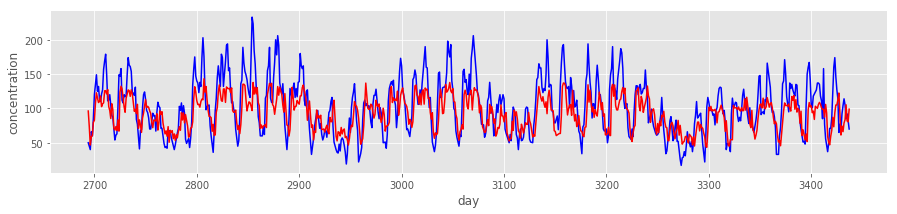

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    52.0
511    49.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    45.0
2695    40.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l1: 34.0267	valid_0's l2: 1733.45
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 33.9193	valid_0's l2: 1724.14
[3]	valid_0's l1: 33.8318	valid_0's l2: 1716.08
[4]	valid_0's l1: 33.7654	valid_0's l2: 1709.27
[5]	valid_0's l1: 33.6605	valid_0's l2: 1700.43
[6]	valid_0's l1: 33.5754	valid_0's l2: 1693.42
[7]	valid_0's l1: 33.4916	valid_0's l2: 1686.56
[8]	valid_0's l1: 33.3915	valid_0's l2: 1678.18
[9]	valid_0's

[197]	valid_0's l1: 27.384	valid_0's l2: 1227.74
[198]	valid_0's l1: 27.38	valid_0's l2: 1227.57
[199]	valid_0's l1: 27.3783	valid_0's l2: 1227.42
[200]	valid_0's l1: 27.376	valid_0's l2: 1227.24
[201]	valid_0's l1: 27.366	valid_0's l2: 1226.71
[202]	valid_0's l1: 27.3557	valid_0's l2: 1226.14
[203]	valid_0's l1: 27.3474	valid_0's l2: 1225.43
[204]	valid_0's l1: 27.3356	valid_0's l2: 1224.83
[205]	valid_0's l1: 27.3273	valid_0's l2: 1224.11
[206]	valid_0's l1: 27.3211	valid_0's l2: 1223.57
[207]	valid_0's l1: 27.315	valid_0's l2: 1223.1
[208]	valid_0's l1: 27.3107	valid_0's l2: 1222.63
[209]	valid_0's l1: 27.2987	valid_0's l2: 1221.85
[210]	valid_0's l1: 27.2892	valid_0's l2: 1221.21
[211]	valid_0's l1: 27.2779	valid_0's l2: 1220.42
[212]	valid_0's l1: 27.2733	valid_0's l2: 1220.11
[213]	valid_0's l1: 27.2599	valid_0's l2: 1219.33
[214]	valid_0's l1: 27.2469	valid_0's l2: 1218.57
[215]	valid_0's l1: 27.2372	valid_0's l2: 1217.87
[216]	valid_0's l1: 27.2304	valid_0's l2: 1217.59
[217]	v

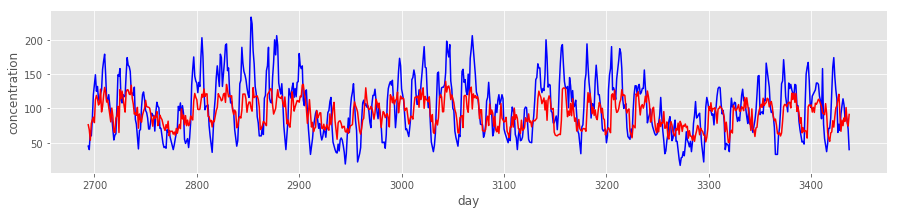

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    49.0
511    50.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    40.0
2695    66.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l1: 34.0763	valid_0's l2: 1739.13
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 33.9904	valid_0's l2: 1733
[3]	valid_0's l1: 33.9416	valid_0's l2: 1728.47
[4]	valid_0's l1: 33.888	valid_0's l2: 1723.53
[5]	valid_0's l1: 33.8089	valid_0's l2: 1718.04
[6]	valid_0's l1: 33.7425	valid_0's l2: 1713.17
[7]	valid_0's l1: 33.6752	valid_0's l2: 1708.29
[8]	valid_0's l1: 33.5971	valid_0's l2: 1702.65
[9]	valid_0's l1:

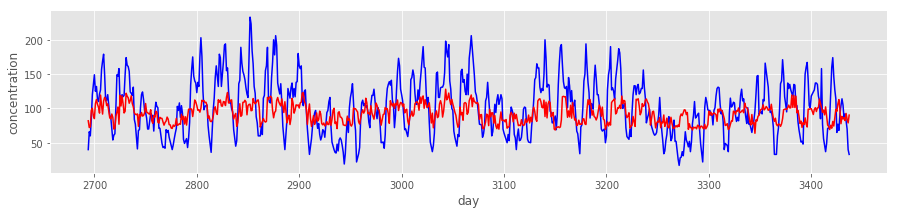

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    50.0
511    67.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    66.0
2695    60.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l1: 34.1025	valid_0's l2: 1741.28
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 34.0384	valid_0's l2: 1736.41
[3]	valid_0's l1: 34.0016	valid_0's l2: 1733.65
[4]	valid_0's l1: 33.9452	valid_0's l2: 1728.02
[5]	valid_0's l1: 33.8818	valid_0's l2: 1723.27
[6]	valid_0's l1: 33.839	valid_0's l2: 1719.57
[7]	valid_0's l1: 33.7865	valid_0's l2: 1715.19
[8]	valid_0's l1: 33.7245	valid_0's l2: 1710.18
[9]	valid_0's 

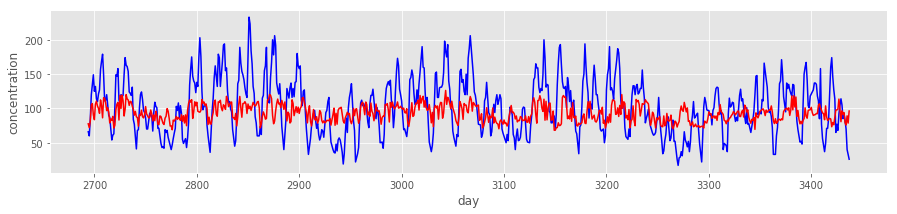

startYearMonth:  2004-05
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    84.0
1231    71.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    70.0
3439    40.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l1: 27.5637	valid_0's l2: 1149.73
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 27.3733	valid_0's l2: 1133.86
[3]	valid_0's l1: 27.1773	valid_0's l2: 1118.17
[4]	valid_0's l1: 27.0311	valid_0's l2: 1105.9
[5]	valid_0's l1: 26.8516	valid_0's l2: 1090.96
[6]	valid_0's l1: 26.6909	valid_0's l2: 1076.54
[7]	valid_0's l1: 26.532	valid_0's l2: 1062.41
[8]	valid_0's l1: 26.3558	valid_0

[170]	valid_0's l1: 15.2055	valid_0's l2: 358.715
[171]	valid_0's l1: 15.1849	valid_0's l2: 357.919
[172]	valid_0's l1: 15.1601	valid_0's l2: 357.023
[173]	valid_0's l1: 15.1372	valid_0's l2: 356.136
[174]	valid_0's l1: 15.1139	valid_0's l2: 355.258
[175]	valid_0's l1: 15.0999	valid_0's l2: 354.886
[176]	valid_0's l1: 15.0777	valid_0's l2: 354.149
[177]	valid_0's l1: 15.0557	valid_0's l2: 353.429
[178]	valid_0's l1: 15.0363	valid_0's l2: 352.689
[179]	valid_0's l1: 15.0146	valid_0's l2: 352.138
[180]	valid_0's l1: 14.9933	valid_0's l2: 351.601
[181]	valid_0's l1: 14.973	valid_0's l2: 350.842
[182]	valid_0's l1: 14.9526	valid_0's l2: 350.09
[183]	valid_0's l1: 14.9325	valid_0's l2: 349.348
[184]	valid_0's l1: 14.9146	valid_0's l2: 348.99
[185]	valid_0's l1: 14.8974	valid_0's l2: 348.641
[186]	valid_0's l1: 14.8752	valid_0's l2: 348.056
[187]	valid_0's l1: 14.8627	valid_0's l2: 347.551
[188]	valid_0's l1: 14.8435	valid_0's l2: 346.813
[189]	valid_0's l1: 14.8368	valid_0's l2: 346.649
[19

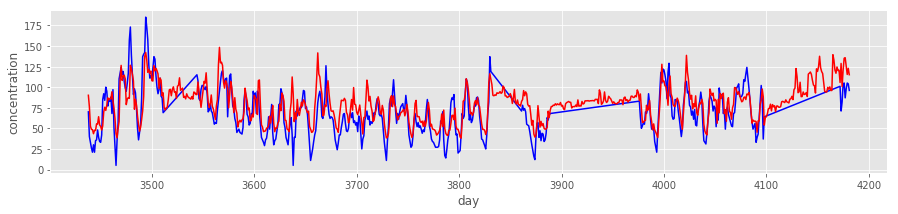

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    71.0
1231    56.5
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    40.0
3439    33.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l1: 27.5784	valid_0's l2: 1151.86
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 27.4232	valid_0's l2: 1139.32
[3]	valid_0's l1: 27.2567	valid_0's l2: 1126.58
[4]	valid_0's l1: 27.1405	valid_0's l2: 1117.2
[5]	valid_0's l1: 26.9908	valid_0's l2: 1105.29
[6]	valid_0's l1: 26.8476	valid_0's l2: 1093.39
[7]	valid_0's l1: 26.7086	valid_0's l2: 1081.81
[8]	valid_0's l1: 26.5719	valid_0's l2: 1070.6
[9]	valid_

[171]	valid_0's l1: 17.2626	valid_0's l2: 485.8
[172]	valid_0's l1: 17.2427	valid_0's l2: 485.003
[173]	valid_0's l1: 17.2235	valid_0's l2: 484.228
[174]	valid_0's l1: 17.2046	valid_0's l2: 483.475
[175]	valid_0's l1: 17.1919	valid_0's l2: 483.212
[176]	valid_0's l1: 17.1724	valid_0's l2: 482.375
[177]	valid_0's l1: 17.153	valid_0's l2: 481.557
[178]	valid_0's l1: 17.1361	valid_0's l2: 480.788
[179]	valid_0's l1: 17.1078	valid_0's l2: 479.867
[180]	valid_0's l1: 17.0796	valid_0's l2: 478.946
[181]	valid_0's l1: 17.0647	valid_0's l2: 478.215
[182]	valid_0's l1: 17.0467	valid_0's l2: 477.442
[183]	valid_0's l1: 17.0294	valid_0's l2: 476.704
[184]	valid_0's l1: 17.0159	valid_0's l2: 476.403
[185]	valid_0's l1: 17.0038	valid_0's l2: 476.141
[186]	valid_0's l1: 16.9817	valid_0's l2: 475.479
[187]	valid_0's l1: 16.9714	valid_0's l2: 474.931
[188]	valid_0's l1: 16.9599	valid_0's l2: 474.269
[189]	valid_0's l1: 16.9475	valid_0's l2: 473.996
[190]	valid_0's l1: 16.9278	valid_0's l2: 473.401
[19

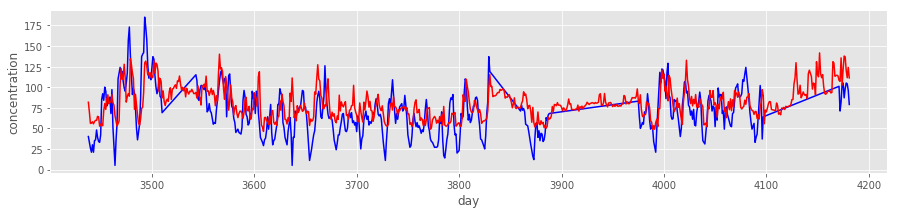

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    56.5
1231    42.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    33.0
3439    26.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l1: 27.5815	valid_0's l2: 1152.39
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 27.4561	valid_0's l2: 1142.93
[3]	valid_0's l1: 27.3131	valid_0's l2: 1133.17
[4]	valid_0's l1: 27.2163	valid_0's l2: 1126.18
[5]	valid_0's l1: 27.0988	valid_0's l2: 1117.34
[6]	valid_0's l1: 27.0014	valid_0's l2: 1109.16
[7]	valid_0's l1: 26.9053	valid_0's l2: 1101.1
[8]	valid_0's l1: 26.7787	valid_0's l2: 1091.45
[9]	valid

[194]	valid_0's l1: 18.7905	valid_0's l2: 609.214
[195]	valid_0's l1: 18.7841	valid_0's l2: 608.767
[196]	valid_0's l1: 18.7721	valid_0's l2: 608.088
[197]	valid_0's l1: 18.7566	valid_0's l2: 607.32
[198]	valid_0's l1: 18.7445	valid_0's l2: 606.556
[199]	valid_0's l1: 18.7295	valid_0's l2: 605.839
[200]	valid_0's l1: 18.7158	valid_0's l2: 605.15
[201]	valid_0's l1: 18.7102	valid_0's l2: 604.84
[202]	valid_0's l1: 18.705	valid_0's l2: 604.537
[203]	valid_0's l1: 18.702	valid_0's l2: 604.626
[204]	valid_0's l1: 18.6996	valid_0's l2: 604.397
[205]	valid_0's l1: 18.6974	valid_0's l2: 604.509
[206]	valid_0's l1: 18.6891	valid_0's l2: 604.107
[207]	valid_0's l1: 18.6812	valid_0's l2: 603.719
[208]	valid_0's l1: 18.674	valid_0's l2: 603.354
[209]	valid_0's l1: 18.6628	valid_0's l2: 602.745
[210]	valid_0's l1: 18.6611	valid_0's l2: 602.743
[211]	valid_0's l1: 18.664	valid_0's l2: 602.862
[212]	valid_0's l1: 18.6588	valid_0's l2: 602.36
[213]	valid_0's l1: 18.6572	valid_0's l2: 602.057
[214]	va

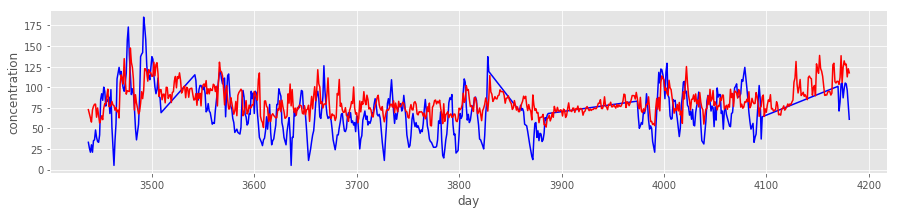

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    42.0
1231    32.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    26.0
3439    21.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l1: 27.5647	valid_0's l2: 1151.18
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 27.4813	valid_0's l2: 1144.89
[3]	valid_0's l1: 27.3805	valid_0's l2: 1137.75
[4]	valid_0's l1: 27.3011	valid_0's l2: 1132.26
[5]	valid_0's l1: 27.222	valid_0's l2: 1126.31
[6]	valid_0's l1: 27.1476	valid_0's l2: 1120.13
[7]	valid_0's l1: 27.0762	valid_0's l2: 1114.12
[8]	valid_0's l1: 26.9965	valid_0's l2: 1108.41
[9]	valid

[171]	valid_0's l1: 20.4281	valid_0's l2: 729.483
[172]	valid_0's l1: 20.4081	valid_0's l2: 728.767
[173]	valid_0's l1: 20.3888	valid_0's l2: 728.074
[174]	valid_0's l1: 20.3691	valid_0's l2: 727.224
[175]	valid_0's l1: 20.3649	valid_0's l2: 727.236
[176]	valid_0's l1: 20.3629	valid_0's l2: 727.117
[177]	valid_0's l1: 20.366	valid_0's l2: 726.982
[178]	valid_0's l1: 20.3534	valid_0's l2: 726.476
[179]	valid_0's l1: 20.3384	valid_0's l2: 725.921
[180]	valid_0's l1: 20.3225	valid_0's l2: 725.251
[181]	valid_0's l1: 20.3155	valid_0's l2: 725.082
[182]	valid_0's l1: 20.309	valid_0's l2: 724.846
[183]	valid_0's l1: 20.3031	valid_0's l2: 724.622
[184]	valid_0's l1: 20.2933	valid_0's l2: 724.333
[185]	valid_0's l1: 20.2864	valid_0's l2: 724.08
[186]	valid_0's l1: 20.2723	valid_0's l2: 723.374
[187]	valid_0's l1: 20.263	valid_0's l2: 722.757
[188]	valid_0's l1: 20.2571	valid_0's l2: 722.599
[189]	valid_0's l1: 20.251	valid_0's l2: 722.438
[190]	valid_0's l1: 20.24	valid_0's l2: 721.812
[191]	v

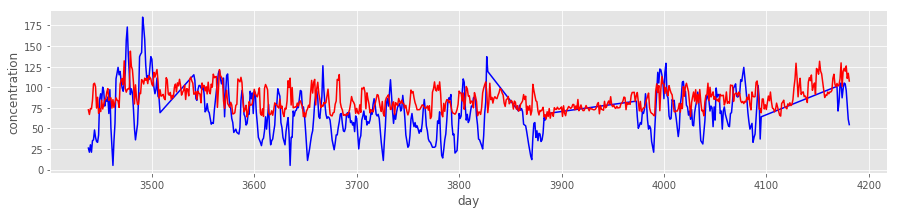

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    32.0
1231    35.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    21.0
3439    30.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l1: 27.5351	valid_0's l2: 1148.23
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 27.4643	valid_0's l2: 1142.69
[3]	valid_0's l1: 27.3616	valid_0's l2: 1136.56
[4]	valid_0's l1: 27.2751	valid_0's l2: 1130.54
[5]	valid_0's l1: 27.2122	valid_0's l2: 1125.56
[6]	valid_0's l1: 27.1331	valid_0's l2: 1119.52
[7]	valid_0's l1: 27.0585	valid_0's l2: 1113.75
[8]	valid_0's l1: 26.9915	valid_0's l2: 1108.86
[9]	vali

[157]	valid_0's l1: 21.4119	valid_0's l2: 825.992
[158]	valid_0's l1: 21.3972	valid_0's l2: 825.198
[159]	valid_0's l1: 21.3859	valid_0's l2: 824.612
[160]	valid_0's l1: 21.3762	valid_0's l2: 824.125
[161]	valid_0's l1: 21.3704	valid_0's l2: 823.737
[162]	valid_0's l1: 21.3533	valid_0's l2: 822.8
[163]	valid_0's l1: 21.3369	valid_0's l2: 821.888
[164]	valid_0's l1: 21.3322	valid_0's l2: 821.507
[165]	valid_0's l1: 21.3306	valid_0's l2: 821.268
[166]	valid_0's l1: 21.322	valid_0's l2: 820.702
[167]	valid_0's l1: 21.3155	valid_0's l2: 820.223
[168]	valid_0's l1: 21.3088	valid_0's l2: 819.719
[169]	valid_0's l1: 21.3018	valid_0's l2: 819.343
[170]	valid_0's l1: 21.2934	valid_0's l2: 818.862
[171]	valid_0's l1: 21.288	valid_0's l2: 818.454
[172]	valid_0's l1: 21.2796	valid_0's l2: 817.923
[173]	valid_0's l1: 21.2712	valid_0's l2: 817.414
[174]	valid_0's l1: 21.263	valid_0's l2: 816.926
[175]	valid_0's l1: 21.2693	valid_0's l2: 817.23
[176]	valid_0's l1: 21.263	valid_0's l2: 816.895
[177]	v

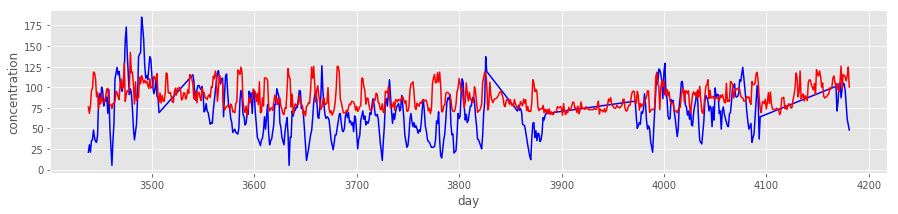

startYearMonth:  2004-06
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    23.0
1975    26.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    79.0
4183    61.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l1: 32.5446	valid_0's l2: 1823.23
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 32.3516	valid_0's l2: 1799.59
[3]	valid_0's l1: 32.1731	valid_0's l2: 1777.59
[4]	valid_0's l1: 31.9572	valid_0's l2: 1755.47
[5]	valid_0's l1: 31.7713	valid_0's l2: 1733.28
[6]	valid_0's l1: 31.601	valid_0's l2: 1713.03
[7]	valid_0's l1: 31.4384	valid_0's l2: 1693.28
[8]	valid_0's l1: 31.2665	valid_

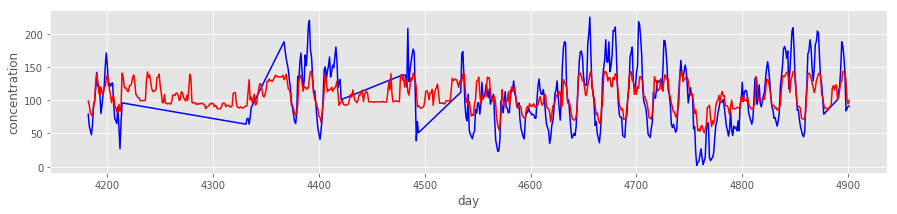

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    26.0
1975    25.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    61.0
4183    54.5
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l1: 32.5969	valid_0's l2: 1828.44
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 32.4346	valid_0's l2: 1809.28
[3]	valid_0's l1: 32.2929	valid_0's l2: 1792.45
[4]	valid_0's l1: 32.1311	valid_0's l2: 1776.36
[5]	valid_0's l1: 31.9728	valid_0's l2: 1758.22
[6]	valid_0's l1: 31.8274	valid_0's l2: 1741.31
[7]	valid_0's l1: 31.6903	valid_0's l2: 1724.84
[8]	valid_0's l1: 31.5594	valid_0's l2: 1709.61
[9]	vali

The rmse of prediction is: 31.25617988784766

Saving model 1...
------------------------------------------------------


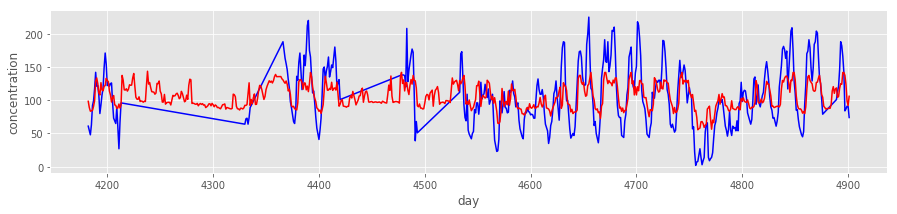

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    25.0
1975    24.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    54.5
4183    48.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l1: 32.6222	valid_0's l2: 1832.3
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 32.5016	valid_0's l2: 1818.76
[3]	valid_0's l1: 32.3894	valid_0's l2: 1805.74
[4]	valid_0's l1: 32.2693	valid_0's l2: 1794.06
[5]	valid_0's l1: 32.1542	valid_0's l2: 1781.26
[6]	valid_0's l1: 32.0525	valid_0's l2: 1768.34
[7]	valid_0's l1: 31.9545	valid_0's l2: 1755.77
[8]	valid_0's l1: 31.8436	valid_0's l2: 1742.43
[9]	valid

[165]	valid_0's l1: 27.0115	valid_0's l2: 1135.8
[166]	valid_0's l1: 27.0053	valid_0's l2: 1135.2
[167]	valid_0's l1: 26.9992	valid_0's l2: 1134.61
[168]	valid_0's l1: 26.9939	valid_0's l2: 1134.06
[169]	valid_0's l1: 26.9908	valid_0's l2: 1133.48
[170]	valid_0's l1: 26.9858	valid_0's l2: 1132.47
[171]	valid_0's l1: 26.9842	valid_0's l2: 1131.94
[172]	valid_0's l1: 26.9815	valid_0's l2: 1131.43
[173]	valid_0's l1: 26.9789	valid_0's l2: 1130.94
[174]	valid_0's l1: 26.9726	valid_0's l2: 1130.11
[175]	valid_0's l1: 26.9584	valid_0's l2: 1128.8
[176]	valid_0's l1: 26.9554	valid_0's l2: 1128.29
[177]	valid_0's l1: 26.9528	valid_0's l2: 1127.79
[178]	valid_0's l1: 26.9668	valid_0's l2: 1128.1
[179]	valid_0's l1: 26.9637	valid_0's l2: 1127.64
[180]	valid_0's l1: 26.961	valid_0's l2: 1127.2
[181]	valid_0's l1: 26.9574	valid_0's l2: 1126.59
[182]	valid_0's l1: 26.9538	valid_0's l2: 1126
Early stopping, best iteration is:
[177]	valid_0's l1: 26.9528	valid_0's l2: 1127.79
The rmse of prediction i

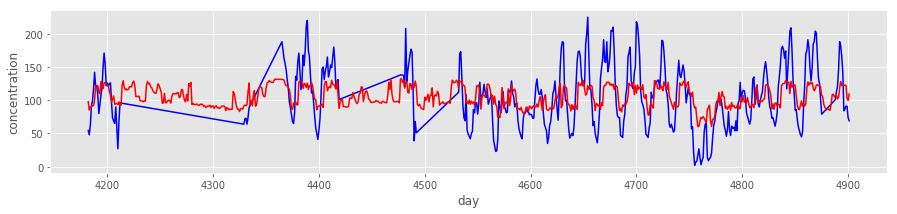

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    24.0
1975    41.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    48.0
4183    63.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l1: 32.6152	valid_0's l2: 1832.03
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 32.5103	valid_0's l2: 1820.13
[3]	valid_0's l1: 32.4104	valid_0's l2: 1808.68
[4]	valid_0's l1: 32.3188	valid_0's l2: 1800.39
[5]	valid_0's l1: 32.2215	valid_0's l2: 1789.72
[6]	valid_0's l1: 32.15	valid_0's l2: 1780.34
[7]	valid_0's l1: 32.082	valid_0's l2: 1771.18
[8]	valid_0's l1: 31.9964	valid_0's l2: 1761.65
[9]	valid_0

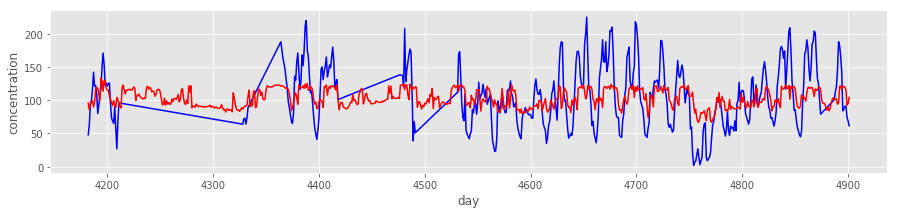

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    41.0
1975    65.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    63.0
4183    92.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l1: 32.6325	valid_0's l2: 1833.58
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 32.5691	valid_0's l2: 1825.43
[3]	valid_0's l1: 32.4876	valid_0's l2: 1815.61
[4]	valid_0's l1: 32.4123	valid_0's l2: 1808.11
[5]	valid_0's l1: 32.353	valid_0's l2: 1800.39
[6]	valid_0's l1: 32.2749	valid_0's l2: 1790.46
[7]	valid_0's l1: 32.2002	valid_0's l2: 1780.77
[8]	valid_0's l1: 32.1324	valid_0's l2: 1771.84
[9]	valid

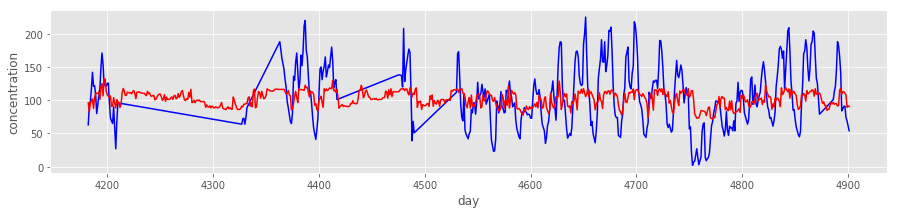

startYearMonth:  2004-07
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    77.0
2695    50.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    74.0
4903    69.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l1: 28.5239	valid_0's l2: 1234.84
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 28.3112	valid_0's l2: 1217.42
[3]	valid_0's l1: 28.1016	valid_0's l2: 1200.6
[4]	valid_0's l1: 27.9124	valid_0's l2: 1186.15
[5]	valid_0's l1: 27.7154	valid_0's l2: 1170.11
[6]	valid_0's l1: 27.531	valid_0's l2: 1155.12
[7]	valid_0's l1: 27.3484	valid_0's l2: 1140.57
[8]	valid_0's l1: 27.1715	valid_0

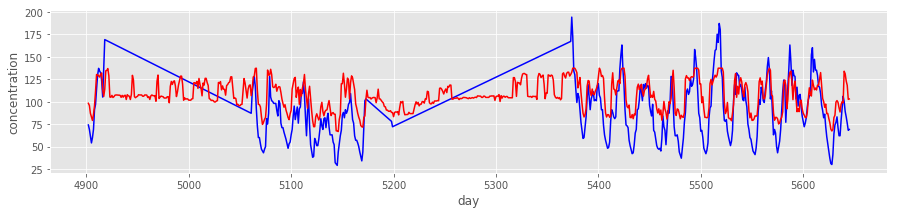

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    50.0
2695    45.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    69.0
4903    61.5
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l1: 28.5614	valid_0's l2: 1237.58
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 28.3907	valid_0's l2: 1223.75
[3]	valid_0's l1: 28.2257	valid_0's l2: 1211.23
[4]	valid_0's l1: 28.0719	valid_0's l2: 1199.69
[5]	valid_0's l1: 27.9076	valid_0's l2: 1186.69
[6]	valid_0's l1: 27.7246	valid_0's l2: 1171.84
[7]	valid_0's l1: 27.5518	valid_0's l2: 1157.9
[8]	valid_0's l1: 27.3954	valid_0's l2: 1145.93
[9]	valid

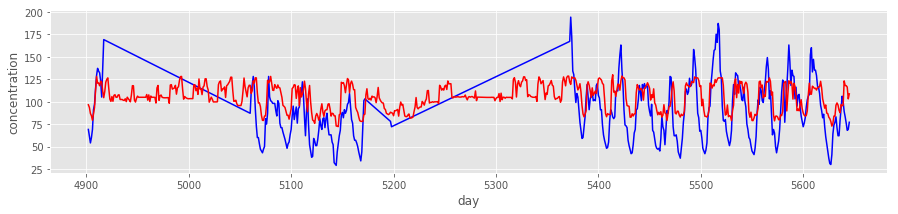

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    45.0
2695    40.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    61.5
4903    54.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l1: 28.5892	valid_0's l2: 1240.85
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 28.4536	valid_0's l2: 1230.28
[3]	valid_0's l1: 28.3217	valid_0's l2: 1220.61
[4]	valid_0's l1: 28.2013	valid_0's l2: 1211.75
[5]	valid_0's l1: 28.0738	valid_0's l2: 1201.94
[6]	valid_0's l1: 27.937	valid_0's l2: 1191.49
[7]	valid_0's l1: 27.8034	valid_0's l2: 1181.33
[8]	valid_0's l1: 27.6768	valid_0's l2: 1171.65
[9]	valid

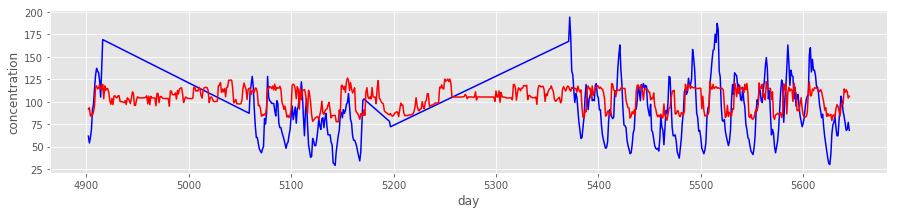

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    40.0
2695    66.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    54.0
4903    60.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l1: 28.6171	valid_0's l2: 1244.53
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 28.5078	valid_0's l2: 1236.12
[3]	valid_0's l1: 28.3916	valid_0's l2: 1227.54
[4]	valid_0's l1: 28.2843	valid_0's l2: 1220.05
[5]	valid_0's l1: 28.1823	valid_0's l2: 1212.2
[6]	valid_0's l1: 28.0688	valid_0's l2: 1204.46
[7]	valid_0's l1: 27.9565	valid_0's l2: 1196.96
[8]	valid_0's l1: 27.849	valid_0's l2: 1189.18
[9]	valid_

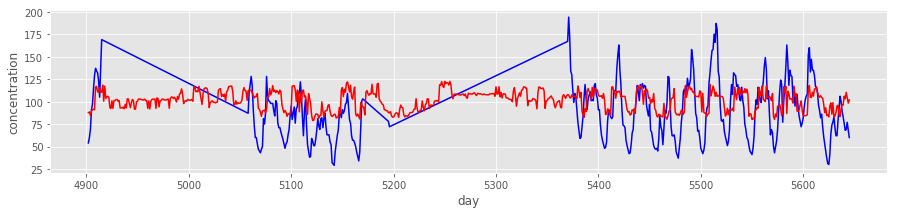

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    66.0
2695    60.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    60.0
4903    69.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l1: 28.6366	valid_0's l2: 1246.06
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 28.5354	valid_0's l2: 1238.7
[3]	valid_0's l1: 28.453	valid_0's l2: 1233.89
[4]	valid_0's l1: 28.3631	valid_0's l2: 1227.99
[5]	valid_0's l1: 28.2685	valid_0's l2: 1221.25
[6]	valid_0's l1: 28.1837	valid_0's l2: 1215.91
[7]	valid_0's l1: 28.1009	valid_0's l2: 1210.72
[8]	valid_0's l1: 28.0014	valid_0's l2: 1203.26
[9]	valid_

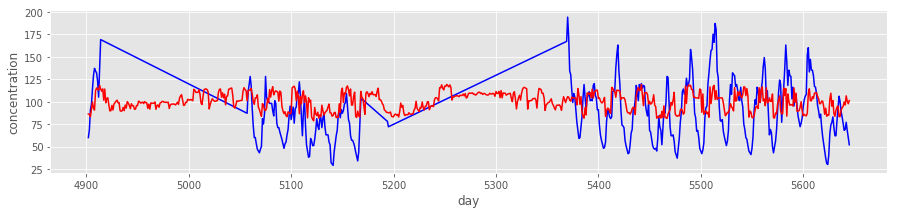

startYearMonth:  2004-08
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    70.0
3439    40.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    77.0
5647    68.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l1: 47.4509	valid_0's l2: 3652.27
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 47.2249	valid_0's l2: 3621.46
[3]	valid_0's l1: 46.999	valid_0's l2: 3590.65
[4]	valid_0's l1: 46.8111	valid_0's l2: 3566.25
[5]	valid_0's l1: 46.5952	valid_0's l2: 3536.94
[6]	valid_0's l1: 46.3813	valid_0's l2: 3507.63
[7]	valid_0's l1: 46.1711	valid_0's l2: 3478.84
[8]	valid_0's l1: 45.973	valid_0

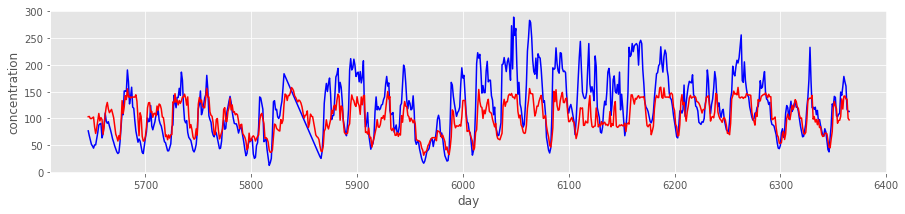

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    40.0
3439    33.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    68.0
5647    60.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l1: 47.4907	valid_0's l2: 3660.44
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 47.3214	valid_0's l2: 3638.58
[3]	valid_0's l1: 47.1575	valid_0's l2: 3616.42
[4]	valid_0's l1: 47.0409	valid_0's l2: 3601.68
[5]	valid_0's l1: 46.8801	valid_0's l2: 3580.92
[6]	valid_0's l1: 46.713	valid_0's l2: 3557.89
[7]	valid_0's l1: 46.5498	valid_0's l2: 3535.3
[8]	valid_0's l1: 46.3766	valid_0's l2: 3511.7
[9]	valid_0

------------------------------------------------------


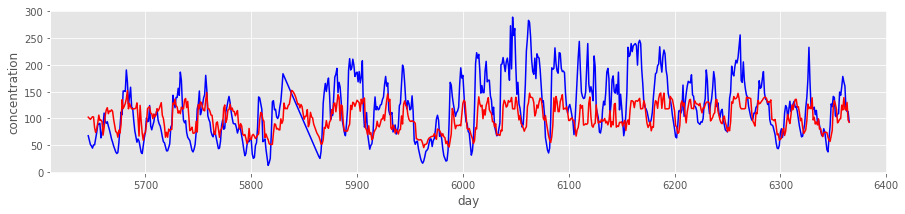

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    33.0
3439    26.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    60.0
5647    52.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l1: 47.529	valid_0's l2: 3665
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 47.4122	valid_0's l2: 3649.47
[3]	valid_0's l1: 47.3049	valid_0's l2: 3634.27
[4]	valid_0's l1: 47.2293	valid_0's l2: 3624.33
[5]	valid_0's l1: 47.1187	valid_0's l2: 3609.55
[6]	valid_0's l1: 47.0122	valid_0's l2: 3594.28
[7]	valid_0's l1: 46.9085	valid_0's l2: 3579.29
[8]	valid_0's l1: 46.7723	valid_0's l2: 3560.38
[9]	valid_0'

[157]	valid_0's l1: 40.6647	valid_0's l2: 2779.85
[158]	valid_0's l1: 40.6457	valid_0's l2: 2776.62
[159]	valid_0's l1: 40.6321	valid_0's l2: 2774.52
[160]	valid_0's l1: 40.6205	valid_0's l2: 2772.73
[161]	valid_0's l1: 40.6122	valid_0's l2: 2771.32
[162]	valid_0's l1: 40.6016	valid_0's l2: 2768.97
[163]	valid_0's l1: 40.5911	valid_0's l2: 2766.66
[164]	valid_0's l1: 40.5827	valid_0's l2: 2765.26
[165]	valid_0's l1: 40.5752	valid_0's l2: 2763.89
[166]	valid_0's l1: 40.5602	valid_0's l2: 2761.78
[167]	valid_0's l1: 40.5472	valid_0's l2: 2759.74
[168]	valid_0's l1: 40.5343	valid_0's l2: 2757.73
[169]	valid_0's l1: 40.5246	valid_0's l2: 2756.42
[170]	valid_0's l1: 40.5067	valid_0's l2: 2754.12
[171]	valid_0's l1: 40.4994	valid_0's l2: 2752.54
[172]	valid_0's l1: 40.4961	valid_0's l2: 2751.85
[173]	valid_0's l1: 40.4929	valid_0's l2: 2751.18
[174]	valid_0's l1: 40.4891	valid_0's l2: 2750.49
[175]	valid_0's l1: 40.4896	valid_0's l2: 2750.82
[176]	valid_0's l1: 40.4721	valid_0's l2: 2748.31


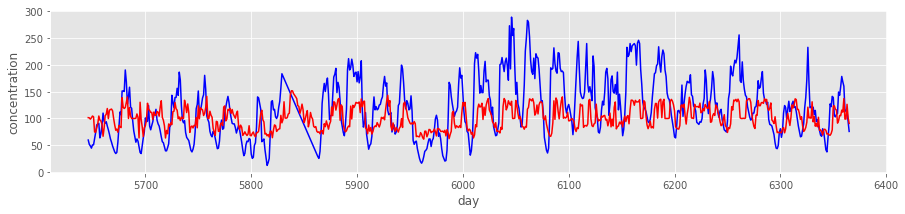

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    26.0
3439    21.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    52.0
5647    49.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l1: 47.5517	valid_0's l2: 3669.99
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 47.4325	valid_0's l2: 3653.65
[3]	valid_0's l1: 47.3587	valid_0's l2: 3642.9
[4]	valid_0's l1: 47.3151	valid_0's l2: 3638.06
[5]	valid_0's l1: 47.2002	valid_0's l2: 3622.36
[6]	valid_0's l1: 47.1213	valid_0's l2: 3609.86
[7]	valid_0's l1: 47.0442	valid_0's l2: 3597.63
[8]	valid_0's l1: 46.9379	valid_0's l2: 3582.96
[9]	valid

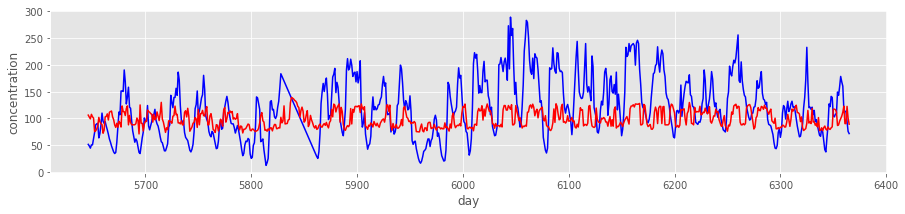

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    21.0
3439    30.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    49.0
5647    45.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l1: 47.5321	valid_0's l2: 3668.71
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 47.4429	valid_0's l2: 3655.48
[3]	valid_0's l1: 47.3736	valid_0's l2: 3644.69
[4]	valid_0's l1: 47.3565	valid_0's l2: 3642.78
[5]	valid_0's l1: 47.2646	valid_0's l2: 3629.39
[6]	valid_0's l1: 47.2175	valid_0's l2: 3622.39
[7]	valid_0's l1: 47.1716	valid_0's l2: 3615.71
[8]	valid_0's l1: 47.1111	valid_0's l2: 3608.01
[9]	vali

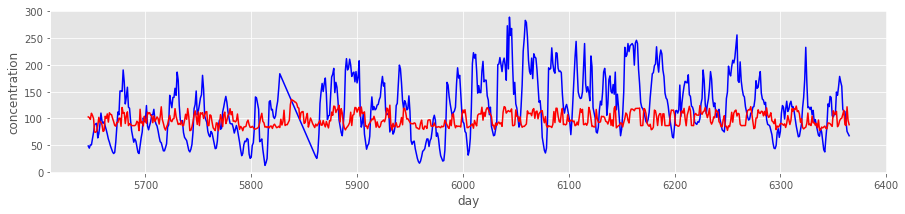

startYearMonth:  2004-09
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    79.0
4183    61.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    94.0
6367    76.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l1: 30.3853	valid_0's l2: 1715.68
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 30.1709	valid_0's l2: 1693.57
[3]	valid_0's l1: 29.9453	valid_0's l2: 1671.23
[4]	valid_0's l1: 29.728	valid_0's l2: 1650.89
[5]	valid_0's l1: 29.5229	valid_0's l2: 1630.07
[6]	valid_0's l1: 29.2899	valid_0's l2: 1607.83
[7]	valid_0's l1: 29.0632	valid_0's l2: 1586.38
[8]	valid_0's l1: 28.8543	valid_

[179]	valid_0's l1: 19.0214	valid_0's l2: 613.654
[180]	valid_0's l1: 19.0141	valid_0's l2: 613.294
[181]	valid_0's l1: 19.0087	valid_0's l2: 612.658
[182]	valid_0's l1: 19.0036	valid_0's l2: 612.051
[183]	valid_0's l1: 18.9995	valid_0's l2: 611.507
[184]	valid_0's l1: 19.0055	valid_0's l2: 611.525
[185]	valid_0's l1: 19.0117	valid_0's l2: 611.558
[186]	valid_0's l1: 19.0094	valid_0's l2: 611.292
[187]	valid_0's l1: 19.0065	valid_0's l2: 610.932
[188]	valid_0's l1: 19.0038	valid_0's l2: 610.651
Early stopping, best iteration is:
[183]	valid_0's l1: 18.9995	valid_0's l2: 611.507
The rmse of prediction is: 24.728662995538407

Saving model 0...
------------------------------------------------------


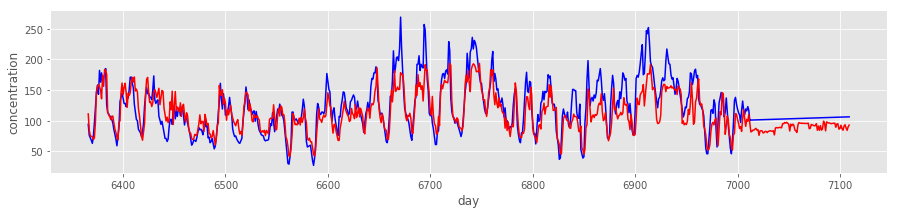

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    61.0
4183    54.5
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    76.0
6367    72.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l1: 30.41	valid_0's l2: 1720.33
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 30.2394	valid_0's l2: 1702.71
[3]	valid_0's l1: 30.0665	valid_0's l2: 1685.52
[4]	valid_0's l1: 29.9179	valid_0's l2: 1672.17
[5]	valid_0's l1: 29.7603	valid_0's l2: 1655.95
[6]	valid_0's l1: 29.5722	valid_0's l2: 1639.05
[7]	valid_0's l1: 29.3876	valid_0's l2: 1622.55
[8]	valid_0's l1: 29.2132	valid_0's l2: 1606.05
[9]	valid_

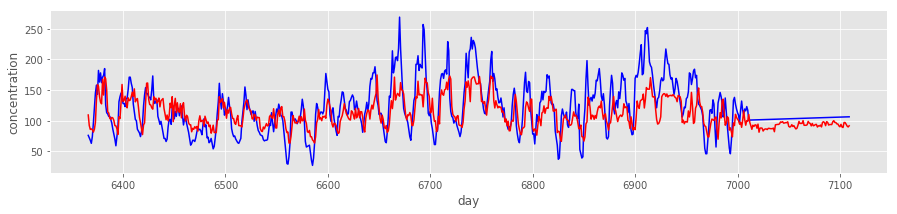

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    54.5
4183    48.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    72.0
6367    68.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l1: 30.4459	valid_0's l2: 1724.53
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 30.3154	valid_0's l2: 1712.11
[3]	valid_0's l1: 30.1861	valid_0's l2: 1699.48
[4]	valid_0's l1: 30.086	valid_0's l2: 1689.51
[5]	valid_0's l1: 29.9658	valid_0's l2: 1678.18
[6]	valid_0's l1: 29.815	valid_0's l2: 1665.69
[7]	valid_0's l1: 29.6682	valid_0's l2: 1653.65
[8]	valid_0's l1: 29.5572	valid_0's l2: 1642.23
[9]	valid_

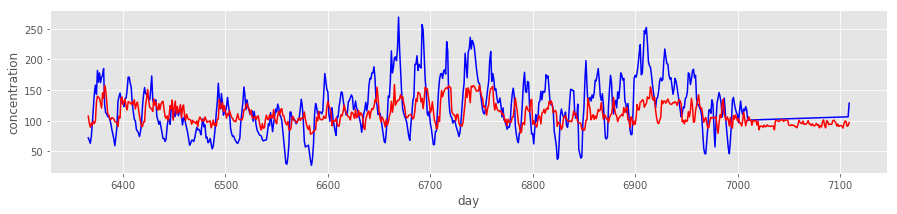

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    48.0
4183    63.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    68.0
6367    63.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l1: 30.4592	valid_0's l2: 1726.91
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 30.3795	valid_0's l2: 1718.03
[3]	valid_0's l1: 30.3031	valid_0's l2: 1709.44
[4]	valid_0's l1: 30.2396	valid_0's l2: 1703.44
[5]	valid_0's l1: 30.1556	valid_0's l2: 1694.83
[6]	valid_0's l1: 30.0388	valid_0's l2: 1685.94
[7]	valid_0's l1: 29.9279	valid_0's l2: 1677.36
[8]	valid_0's l1: 29.8446	valid_0's l2: 1668.42
[9]	vali

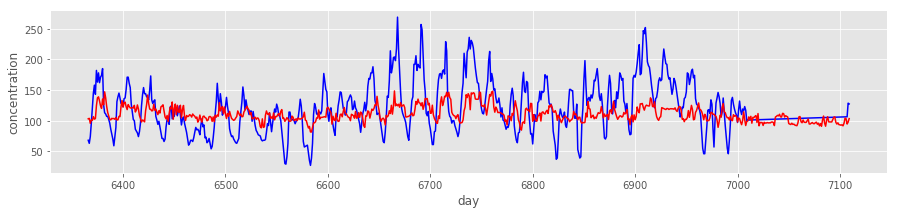

X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    63.0
4183    92.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    63.0
6367    74.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l1: 30.4434	valid_0's l2: 1728.23
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 30.3591	valid_0's l2: 1720.67
[3]	valid_0's l1: 30.3042	valid_0's l2: 1715.07
[4]	valid_0's l1: 30.2541	valid_0's l2: 1710.88
[5]	valid_0's l1: 30.174	valid_0's l2: 1703.78
[6]	valid_0's l1: 30.0945	valid_0's l2: 1697.27
[7]	valid_0's l1: 30.0163	valid_0's l2: 1690.92
[8]	valid_0's l1: 29.9574	valid_0's l2: 1684.73
[9]	valid

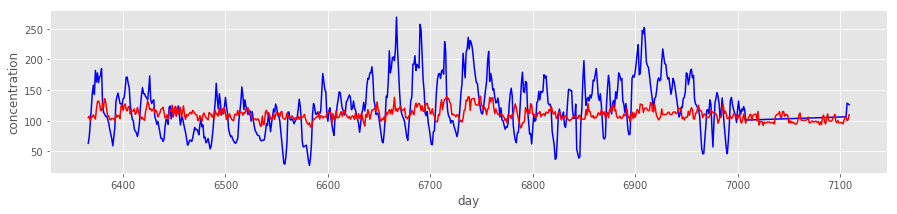

[[22.05317957713736, 28.197451278546904, 32.46439682065607, 34.39058602964879, 35.069920588307696], [25.550728506160013, 30.623084573629317, 34.518845969265, 37.459676979302735, 38.423498383932646], [17.93203890319388, 21.201702420639215, 24.279714869880472, 26.814663288347283, 28.568288690288846], [28.438387442196184, 31.25617988784766, 33.58261318670271, 35.00619759097388, 36.17588608654193], [26.635114276592642, 28.321677319749398, 29.7537442219531, 31.14207465492974, 32.12247790260528], [42.18821406506653, 47.81160084244583, 52.01709338344332, 55.456008170586536, 57.2642870082527], [24.728662995538407, 30.763576452536917, 34.70674704781504, 37.237596233112676, 38.81320861587218]]


In [14]:
# predict CO concentration
print('Starting training...')

# train
# lightGBM + seq2seq workaround: train 5 models
# validation: walk forward validaiton for time series forcasting
def train_lgbm_model(df_X, df_y, futureYList, evaResList, lgbmModelList):    
    
    month_shift = 3
    
    for startYearMonth in df_X.YearMonth.unique():        
        if startYearMonth.month == 12 - month_shift + 1: # stopping criteria
            break 
        print('startYearMonth: ', startYearMonth)
        iterList = []
        for i, labelY in enumerate(futureYList):
            rangeTrainArr = [x for x in range(startYearMonth.month, startYearMonth.month+month_shift)]
            rangeTestArr = [startYearMonth.month+month_shift]
            rangeTrainPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTrainArr]
            rangeTestPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTestArr]
            # segmentaion, use YearMonth as index
            X_train_walk = df_X.loc[df_X.YearMonth.isin(rangeTrainPeriodArray)].copy()
            X_test_walk = df_X.loc[df_X.YearMonth.isin(rangeTestPeriodArray)].copy()        
            y_train_walk = df_y[df_y.index.isin(X_train_walk.index)].copy()
            y_test_walk = df_y[df_y.index.isin(X_test_walk.index)].copy()
            print('X_train_walk:\n', X_train_walk.iloc[:2,:])
            print('y_train_walk:\n', y_train_walk[labelY].iloc[:2])
            print('X_test_walk:\n', X_test_walk.iloc[:2,:])
            print('y_test_walk:\n', y_test_walk[labelY].iloc[:2])
            print('labelY: ', labelY)
            
            X_train_walk.drop(columns=["YearMonth"], inplace=True)
            X_test_walk.drop(columns=["YearMonth"], inplace=True)
            # create dataset for lightgbm                        
            lgb_train = lgb.Dataset(X_train_walk.values, y_train_walk[labelY].values)
            lgb_eval = lgb.Dataset(X_test_walk.values, y_test_walk[labelY].values, reference=lgb_train)    

            # model: share same x parameter, 
            # but y label is future power usage at t+i second
            gbm = lgb.train(params,
                            lgb_train,
                            num_boost_round=300, # num_iterations?
                            valid_sets=lgb_eval,
                            early_stopping_rounds=5)
            # predict
            y_pred = gbm.predict(X_test_walk.values, num_iteration=gbm.best_iteration)
            # eval
            print('The rmse of prediction is:', mean_squared_error(y_test_walk.iloc[:, i].values, y_pred) ** 0.5)             
            iterList.append(mean_squared_error(y_test_walk.iloc[:, i], y_pred) ** 0.5)
            
            # save model to file    
            print('\nSaving model {}...'.format(i))
            modelName = 'lgbmModel' + str(i) + '.txt'
            gbm.save_model(modelName)
            if(startYearMonth.month == 3):
                lgbmModelList.append(modelName)
                
            # plot            
            plt.figure(figsize=(15,3))
            x = X_test_walk.index
            plt.subplot(1, 1, 1)  
            plt.plot(x,y_test_walk.iloc[:, i],'b')
            plt.plot(x,y_pred,'r')            
            plt.xlabel('day')
            plt.ylabel('concentration')
            print ('------------------------------------------------------')
            plt.show()                        
        evaResList.append(iterList)        
    return gbm, lgbmModelList, evaResList
            
lgbmModelList = []                
evaResList = []
gbm, lgbmModelList, evaResList = train_lgbm_model(X_train_norm, y_train, futureYList, lgbmModelList, evaResList)
print(evaResList)

#### evaluates models
* use data range from 2005/01 ~ 2004/02
* as expect, the rmse rise from 1.08 to 1.55 when the time step increase. 

Starting predicting...

lgbmModelList:  ['lgbmModel0.txt', 'lgbmModel1.txt', 'lgbmModel2.txt', 'lgbmModel3.txt', 'lgbmModel4.txt']
model file: lgbmModel0.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.173939  0.095741  0.162572     0.431353
1  0.174419  0.201225  0.162996     0.614301
The rmse of prediction is: 51.18035743897847


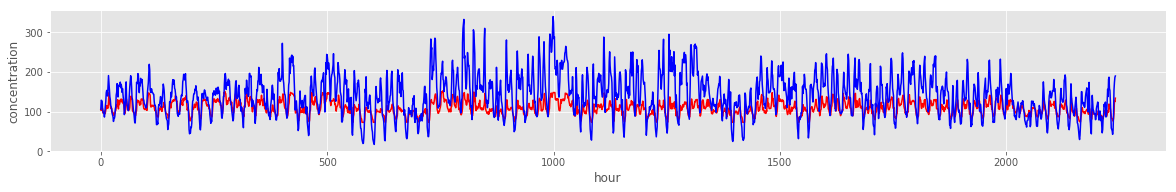

model file: lgbmModel1.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.173939  0.095741  0.162572     0.431353
1  0.174419  0.201225  0.162996     0.614301
The rmse of prediction is: 54.43290048497853


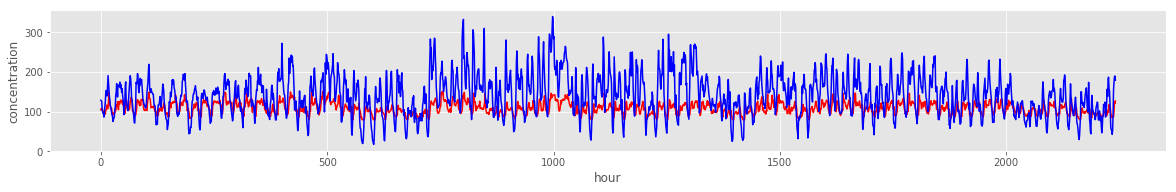

model file: lgbmModel2.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.173939  0.095741  0.162572     0.431353
1  0.174419  0.201225  0.162996     0.614301
The rmse of prediction is: 57.03758172162234


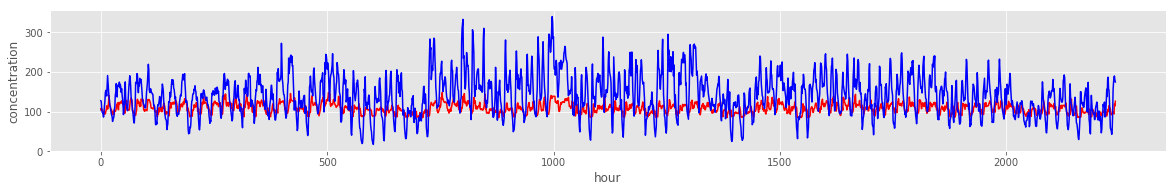

model file: lgbmModel3.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.173939  0.095741  0.162572     0.431353
1  0.174419  0.201225  0.162996     0.614301
The rmse of prediction is: 58.544158105996


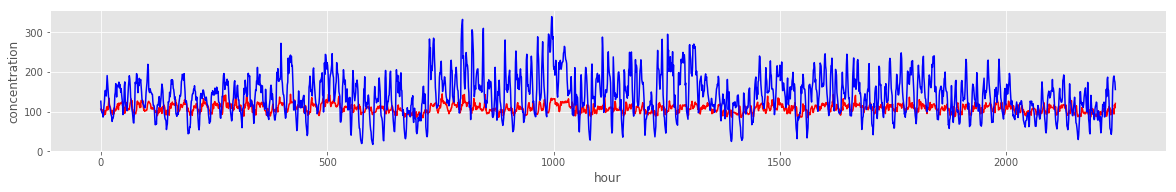

model file: lgbmModel4.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.173939  0.095741  0.162572     0.431353
1  0.174419  0.201225  0.162996     0.614301
The rmse of prediction is: 59.47914200159748


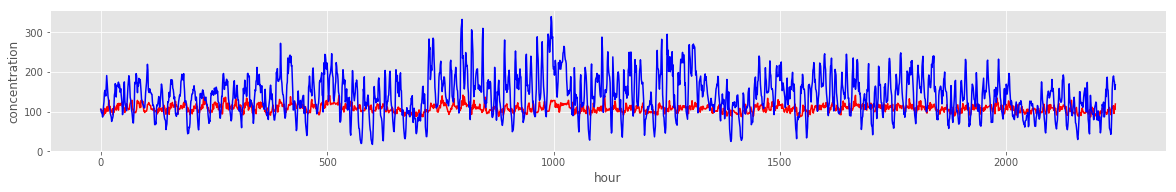

In [15]:
print('Starting predicting...\n')

# model predict and show result seperately
def validation_lgbm_model(df_X, df_y, gbm, lgbmModelList):
    print('lgbmModelList: ', lgbmModelList)
    for i, model in enumerate(lgbmModelList):
        print('model file: {}'.format(model))
        bst = lgb.Booster(model_file = model) # load saved model
        # predict
        X_valid_walk = df_X.drop(columns=["YearMonth"]).copy()
        print(X_valid_walk.iloc[:2,:])
        y_pred = bst.predict(X_valid_walk.values, num_iteration=gbm.best_iteration)            

        # eval
        print('The rmse of prediction is:', mean_squared_error(df_y.iloc[:, i], y_pred) ** 0.5)    
        # plot
        plt.figure(figsize=(20,15))            
        x = X_valid_walk.index
        plt.subplot(len(lgbmModelList), 1, 1)   
        plt.plot(x,y_pred,'r')
        plt.plot(x,y_valid.iloc[:, i],'b')
        plt.xlabel('hour')
        plt.ylabel('concentration')

        plt.show()
        
validation_lgbm_model(X_valid_norm, y_valid, gbm, lgbmModelList)            

#### RNN model
* RNN with LSTM cells

Reference
* [Neural Network Early Stopping](https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/)

In [25]:
config = tf.ConfigProto(device_count={"CPU": 8})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

startYearMonth:  2004-03
X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0     92.0
1    114.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    23.0
1975    26.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (1974, 1, 4) (1974, 5)
Train on 1974 samples, validate on 720 samples
Epoch 1/50
 - 2s - loss: 94.4942 - val_loss: 91.4242
Epoch 2/50
 - 0s - loss: 94.3746 - val_loss: 91.2647
Epoch 3/50
 - 0s - loss: 94.1684 - val_loss: 91.0209
Epoch 4/50
 - 0s - loss: 93.8601 - val_loss: 90.6624
Epoch 5/50
 - 0s - loss: 93.4087 - val_loss: 90.1480
Epoch 6/50
 - 0s - loss: 92.7671 - val_loss: 89.4319
Epoch 7/50
 - 0s - loss: 91.8830 - val_loss: 88.4638
E

<Figure size 720x360 with 0 Axes>

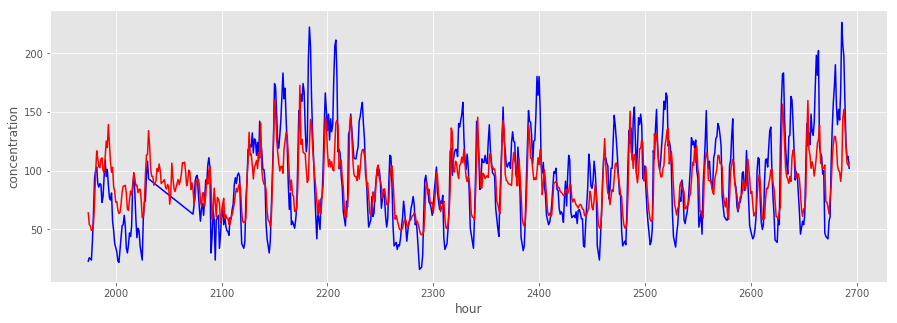

#---------------------------------------#
X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    114.0
1    122.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    26.0
1975    25.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (1974, 1, 4) (1974, 5)
Train on 1974 samples, validate on 720 samples
Epoch 1/50
 - 2s - loss: 94.4896 - val_loss: 91.5374
Epoch 2/50
 - 0s - loss: 94.4147 - val_loss: 91.4594
Epoch 3/50
 - 0s - loss: 94.3257 - val_loss: 91.3599
Epoch 4/50
 - 0s - loss: 94.2099 - val_loss: 91.2305
Epoch 5/50
 - 0s - loss: 94.0568 - val_loss: 91.0606
Epoch 6/50
 - 0s - loss: 93.8545 - val_loss: 90.8386
Epoch 7/50
 - 0s - loss: 93.5897 - va

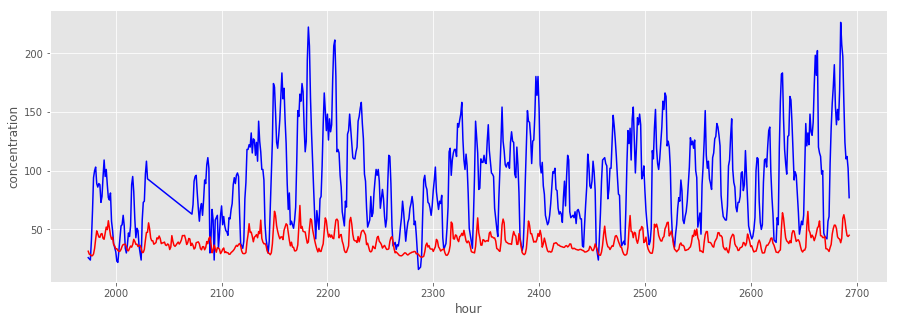

#---------------------------------------#
X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    122.0
1    116.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    25.0
1975    24.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (1974, 1, 4) (1974, 5)
Train on 1974 samples, validate on 720 samples
Epoch 1/50
 - 2s - loss: 94.4451 - val_loss: 91.5554
Epoch 2/50
 - 0s - loss: 94.3381 - val_loss: 91.4454
Epoch 3/50
 - 0s - loss: 94.2103 - val_loss: 91.3020
Epoch 4/50
 - 0s - loss: 94.0362 - val_loss: 91.1038
Epoch 5/50
 - 0s - loss: 93.7937 - val_loss: 90.8302
Epoch 6/50
 - 0s - loss: 93.4589 - val_loss: 90.4582
Epoch 7/50
 - 0s - loss: 93.0057 - va

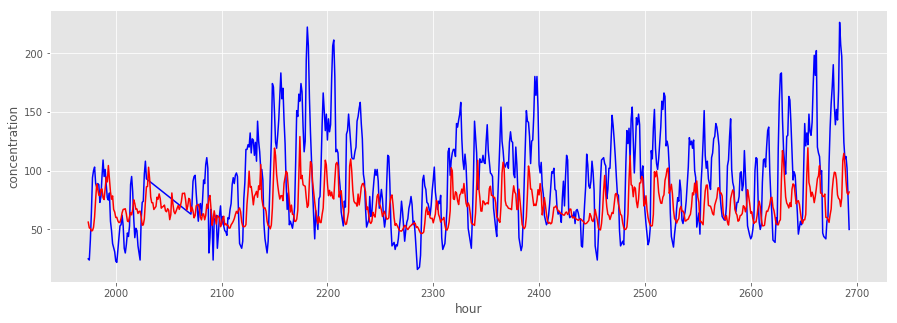

#---------------------------------------#
X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    116.0
1     96.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    24.0
1975    41.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (1974, 1, 4) (1974, 5)
Train on 1974 samples, validate on 720 samples
Epoch 1/50
 - 2s - loss: 94.3287 - val_loss: 91.5081
Epoch 2/50
 - 0s - loss: 94.1781 - val_loss: 91.3267
Epoch 3/50
 - 0s - loss: 93.9250 - val_loss: 91.0089
Epoch 4/50
 - 0s - loss: 93.5230 - val_loss: 90.5441
Epoch 5/50
 - 0s - loss: 92.9378 - val_loss: 89.8805
Epoch 6/50
 - 0s - loss: 92.1101 - val_loss: 88.9605
Epoch 7/50
 - 0s - loss: 90.9747 - va

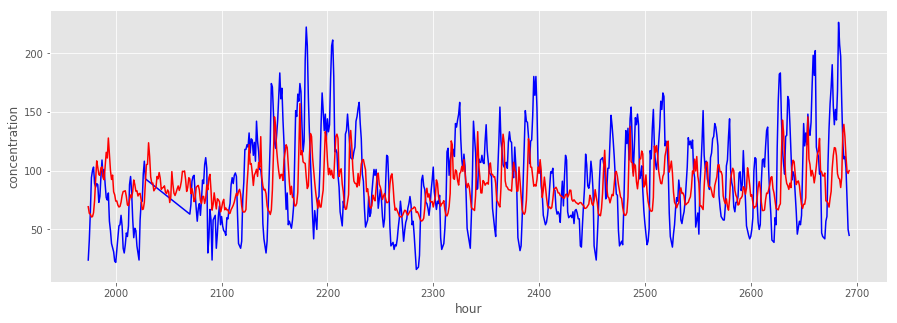

#---------------------------------------#
X_train_walk:
   YearMonth        CO     C6H6       NOx  PT08.S5(O3)
0   2004-03  0.211864  0.18368  0.111036     0.445009
1   2004-03  0.161017  0.14457  0.068382     0.314469
y_train_walk:
 0    96.0
1    77.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_test_walk:
 1974    41.0
1975    65.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (1974, 1, 4) (1974, 5)
Train on 1974 samples, validate on 720 samples
Epoch 1/50
 - 2s - loss: 94.3043 - val_loss: 91.5595
Epoch 2/50
 - 0s - loss: 94.1837 - val_loss: 91.4210
Epoch 3/50
 - 0s - loss: 94.0144 - val_loss: 91.2228
Epoch 4/50
 - 0s - loss: 93.7698 - val_loss: 90.9397
Epoch 5/50
 - 0s - loss: 93.4203 - val_loss: 90.5416
Epoch 6/50
 - 0s - loss: 92.9311 - val_loss: 89.9944
Epoch 7/50
 - 0s - loss: 92.2635 - val_

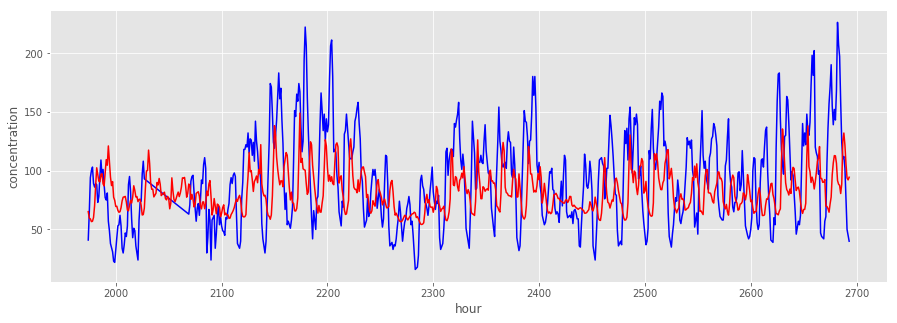

#---------------------------------------#
startYearMonth:  2004-04
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    70.0
511    55.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    77.0
2695    50.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 2s - loss: 92.0048 - val_loss: 102.0169
Epoch 2/50
 - 0s - loss: 91.8464 - val_loss: 101.8146
Epoch 3/50
 - 0s - loss: 91.5915 - val_loss: 101.4973
Epoch 4/50
 - 0s - loss: 91.1934 - val_loss: 101.0091
Epoch 5/50
 - 0s - loss: 90.5941 - val_loss: 100.2892
Epoch 6/50
 - 0s - loss: 89.7286 - val_loss: 99.2

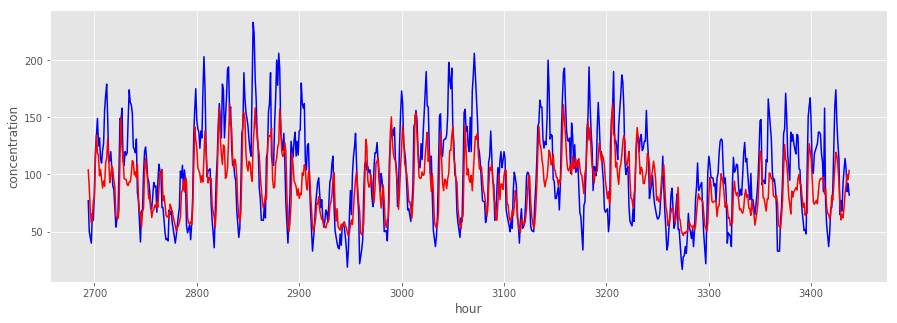

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    55.0
511    52.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    50.0
2695    45.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 2s - loss: 92.0108 - val_loss: 102.0308
Epoch 2/50
 - 0s - loss: 91.9241 - val_loss: 101.9364
Epoch 3/50
 - 0s - loss: 91.8171 - val_loss: 101.8124
Epoch 4/50
 - 0s - loss: 91.6616 - val_loss: 101.6143
Epoch 5/50
 - 0s - loss: 91.4104 - val_loss: 101.3029
Epoch 6/50
 - 0s - loss: 91.0300 - val_loss: 100.8462
Epoch 7/50
 - 0s - l

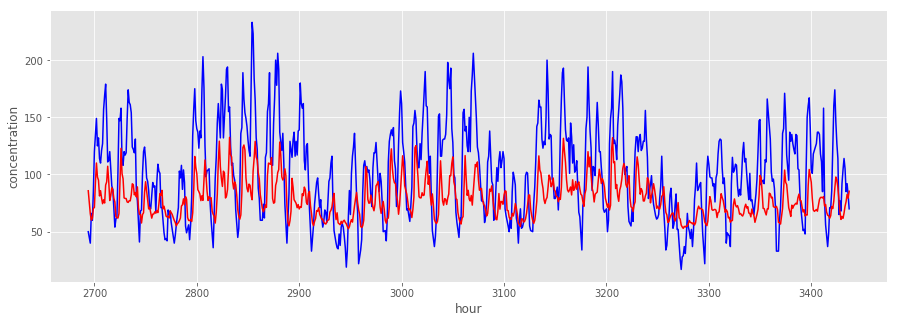

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    52.0
511    49.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    45.0
2695    40.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 2s - loss: 92.0163 - val_loss: 101.9985
Epoch 2/50
 - 0s - loss: 91.8765 - val_loss: 101.8402
Epoch 3/50
 - 0s - loss: 91.6829 - val_loss: 101.6018
Epoch 4/50
 - 0s - loss: 91.3868 - val_loss: 101.2390
Epoch 5/50
 - 0s - loss: 90.9434 - val_loss: 100.7053
Epoch 6/50
 - 0s - loss: 90.3030 - val_loss: 99.9490
Epoch 7/50
 - 0s - lo

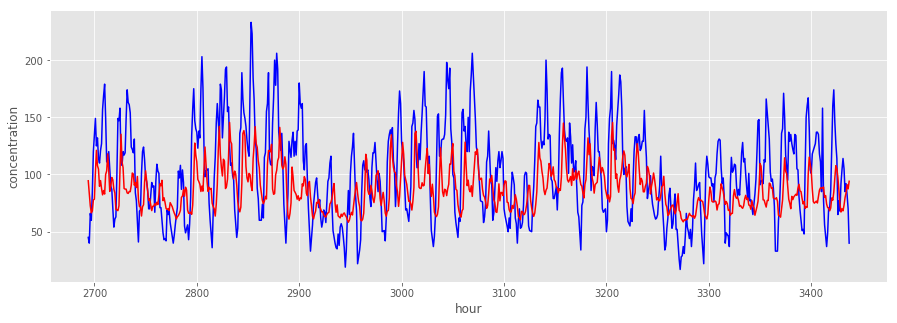

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    49.0
511    50.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    40.0
2695    66.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 3s - loss: 91.9549 - val_loss: 101.9155
Epoch 2/50
 - 0s - loss: 91.7575 - val_loss: 101.6528
Epoch 3/50
 - 0s - loss: 91.4109 - val_loss: 101.2180
Epoch 4/50
 - 0s - loss: 90.8599 - val_loss: 100.5399
Epoch 5/50
 - 0s - loss: 90.0196 - val_loss: 99.5276
Epoch 6/50
 - 0s - loss: 88.7926 - val_loss: 98.0785
Epoch 7/50
 - 0s - los

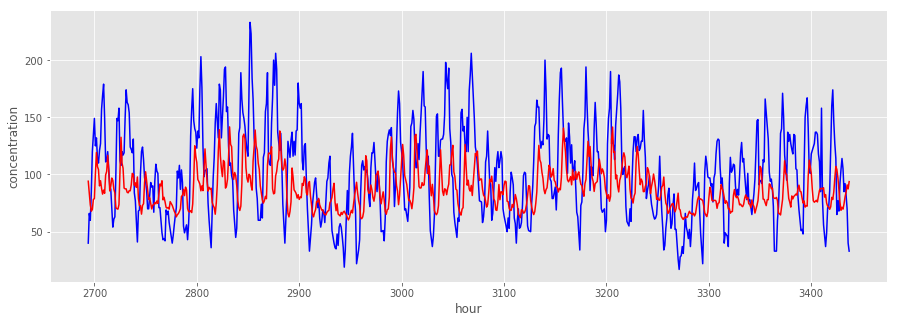

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
510   2004-04  0.127119  0.095690  0.063643     0.317122
511   2004-04  0.093220  0.077263  0.056195     0.302089
y_train_walk:
 510    50.0
511    67.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_test_walk:
 2694    66.0
2695    60.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 3s - loss: 91.9929 - val_loss: 101.9610
Epoch 2/50
 - 0s - loss: 91.8732 - val_loss: 101.8143
Epoch 3/50
 - 0s - loss: 91.6875 - val_loss: 101.5818
Epoch 4/50
 - 0s - loss: 91.3967 - val_loss: 101.2238
Epoch 5/50
 - 0s - loss: 90.9576 - val_loss: 100.6938
Epoch 6/50
 - 0s - loss: 90.3206 - val_loss: 99.9401
Epoch 7/50
 - 0s - lo

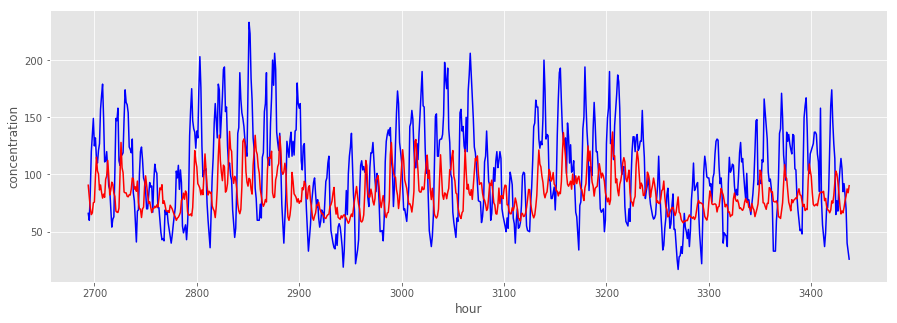

#---------------------------------------#
startYearMonth:  2004-05
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    84.0
1231    71.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    70.0
3439    40.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 3s - loss: 95.3931 - val_loss: 72.8955
Epoch 2/50
 - 0s - loss: 95.1814 - val_loss: 72.6422
Epoch 3/50
 - 0s - loss: 94.8093 - val_loss: 72.2499
Epoch 4/50
 - 0s - loss: 94.2320 - val_loss: 71.6670
Epoch 5/50
 - 0s - loss: 93.3655 - val_loss: 70.8278
Epoch 6/50
 - 0s - loss: 92.1136 - val_loss: 69.6

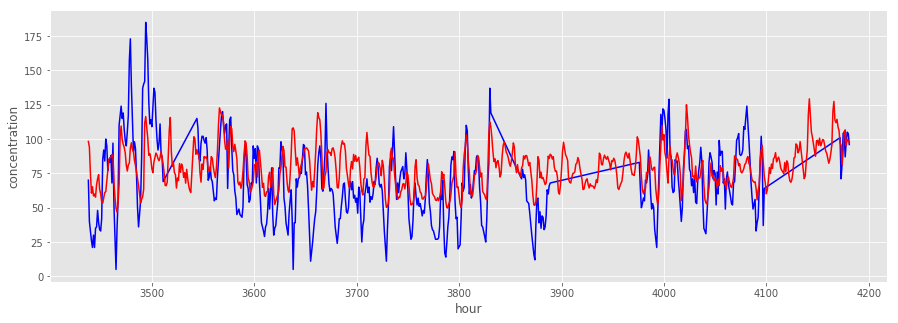

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    71.0
1231    56.5
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    40.0
3439    33.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 3s - loss: 95.3889 - val_loss: 72.9022
Epoch 2/50
 - 0s - loss: 95.1744 - val_loss: 72.6569
Epoch 3/50
 - 0s - loss: 94.8074 - val_loss: 72.2622
Epoch 4/50
 - 0s - loss: 94.2420 - val_loss: 71.6989
Epoch 5/50
 - 0s - loss: 93.4205 - val_loss: 70.9108
Epoch 6/50
 - 0s - loss: 92.2619 - val_loss: 69.8372
Epoch 7/50
 - 0s - lo

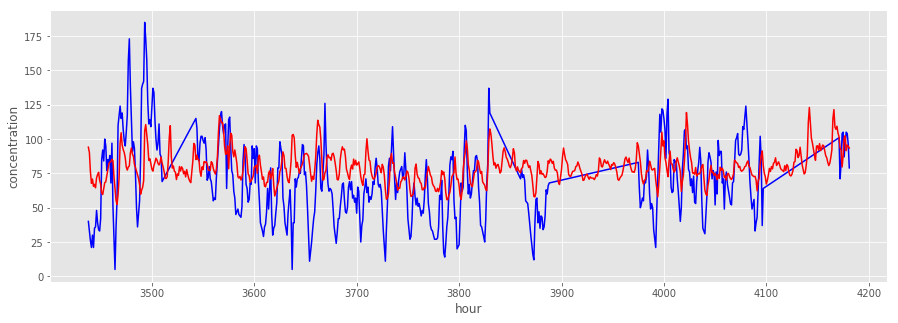

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    56.5
1231    42.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    33.0
3439    26.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 3s - loss: 95.3689 - val_loss: 72.9312
Epoch 2/50
 - 0s - loss: 95.1695 - val_loss: 72.7205
Epoch 3/50
 - 0s - loss: 94.8719 - val_loss: 72.4147
Epoch 4/50
 - 0s - loss: 94.4277 - val_loss: 71.9755
Epoch 5/50
 - 0s - loss: 93.7806 - val_loss: 71.3593
Epoch 6/50
 - 0s - loss: 92.8660 - val_loss: 70.5178
Epoch 7/50
 - 0s - lo

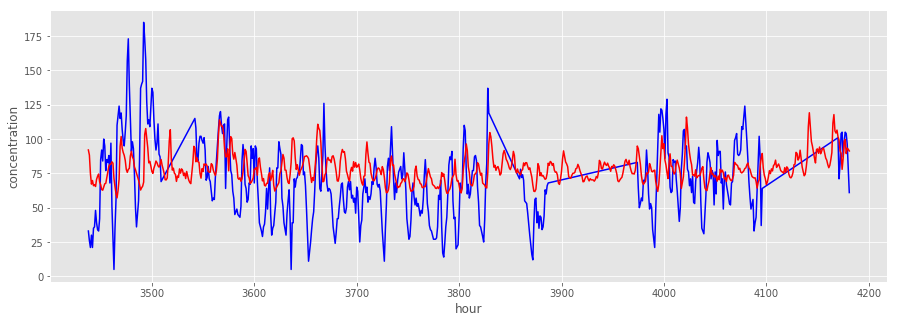

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    42.0
1231    32.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    26.0
3439    21.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 4s - loss: 95.4098 - val_loss: 73.0072
Epoch 2/50
 - 0s - loss: 95.2549 - val_loss: 72.8537
Epoch 3/50
 - 0s - loss: 95.0596 - val_loss: 72.6574
Epoch 4/50
 - 0s - loss: 94.7969 - val_loss: 72.3963
Epoch 5/50
 - 0s - loss: 94.4368 - val_loss: 72.0487
Epoch 6/50
 - 0s - loss: 93.9477 - val_loss: 71.5909
Epoch 7/50
 - 0s - lo

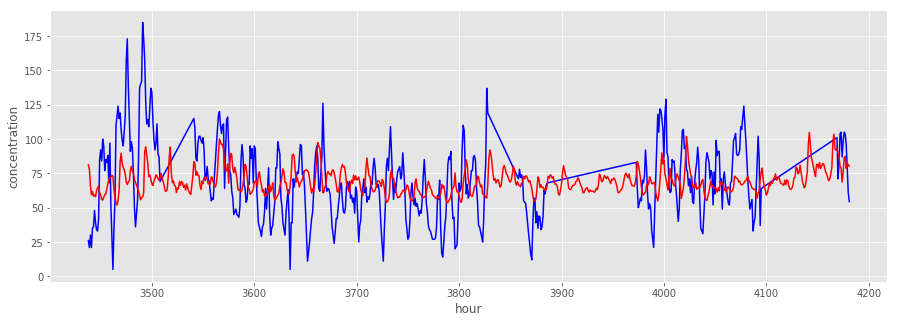

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1230   2004-05  0.288136  0.235723  0.123900     0.675473
1231   2004-05  0.194915  0.142937  0.085985     0.469327
y_train_walk:
 1230    32.0
1231    35.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_test_walk:
 3438    21.0
3439    30.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 4s - loss: 95.4160 - val_loss: 73.0506
Epoch 2/50
 - 0s - loss: 95.2713 - val_loss: 72.9064
Epoch 3/50
 - 0s - loss: 95.0887 - val_loss: 72.7194
Epoch 4/50
 - 0s - loss: 94.8385 - val_loss: 72.4667
Epoch 5/50
 - 0s - loss: 94.4898 - val_loss: 72.1263
Epoch 6/50
 - 0s - loss: 94.0103 - val_loss: 71.6738
Epoch 7/50
 - 0s - lo

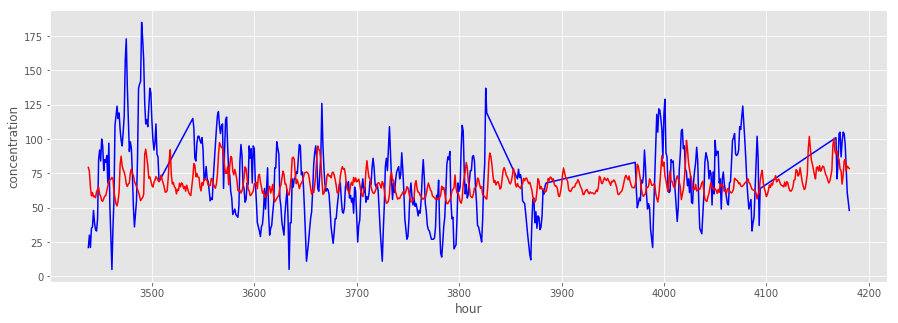

#---------------------------------------#
startYearMonth:  2004-06
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    23.0
1975    26.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    79.0
4183    61.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 4s - loss: 88.7760 - val_loss: 102.4616
Epoch 2/50
 - 0s - loss: 88.5994 - val_loss: 102.1852
Epoch 3/50
 - 0s - loss: 88.2982 - val_loss: 101.7088
Epoch 4/50
 - 0s - loss: 87.8160 - val_loss: 100.9426
Epoch 5/50
 - 0s - loss: 87.0821 - val_loss: 99.7737
Epoch 6/50
 - 0s - loss: 86.0140 - val_loss: 

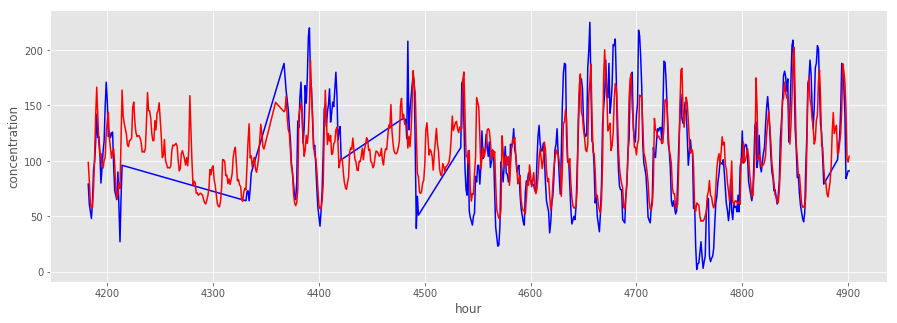

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    26.0
1975    25.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    61.0
4183    54.5
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 4s - loss: 88.8328 - val_loss: 102.4990
Epoch 2/50
 - 0s - loss: 88.6770 - val_loss: 102.2977
Epoch 3/50
 - 0s - loss: 88.4743 - val_loss: 102.0056
Epoch 4/50
 - 0s - loss: 88.1862 - val_loss: 101.5728
Epoch 5/50
 - 0s - loss: 87.7754 - val_loss: 100.9430
Epoch 6/50
 - 0s - loss: 87.2005 - val_loss: 100.0526
Epoch 7/50
 - 0

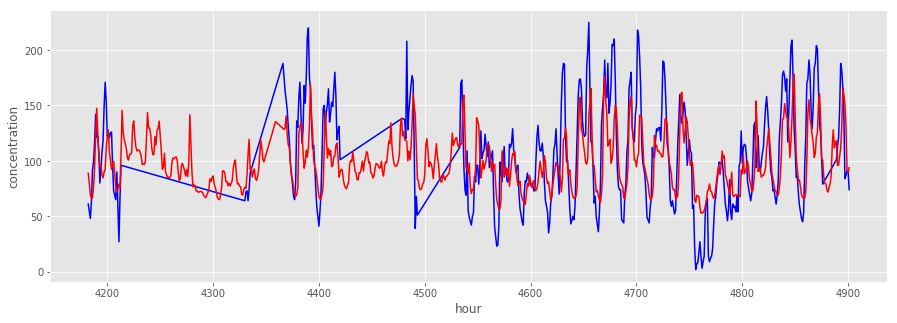

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    25.0
1975    24.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    54.5
4183    48.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 4s - loss: 88.8132 - val_loss: 102.4801
Epoch 2/50
 - 0s - loss: 88.6358 - val_loss: 102.2402
Epoch 3/50
 - 0s - loss: 88.3785 - val_loss: 101.8717
Epoch 4/50
 - 0s - loss: 88.0005 - val_loss: 101.3131
Epoch 5/50
 - 0s - loss: 87.4542 - val_loss: 100.4908
Epoch 6/50
 - 0s - loss: 86.6850 - val_loss: 99.3205
Epoch 7/50
 - 0s

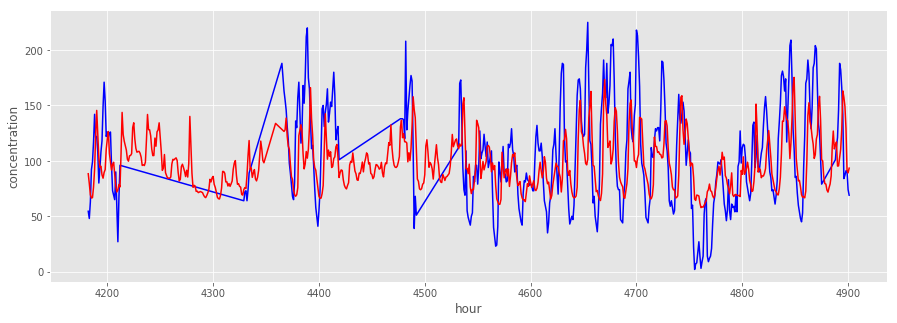

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    24.0
1975    41.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    48.0
4183    63.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 6s - loss: 88.8553 - val_loss: 102.5362
Epoch 2/50
 - 0s - loss: 88.6946 - val_loss: 102.3073
Epoch 3/50
 - 0s - loss: 88.4368 - val_loss: 101.9230
Epoch 4/50
 - 0s - loss: 88.0303 - val_loss: 101.3039
Epoch 5/50
 - 0s - loss: 87.4146 - val_loss: 100.3562
Epoch 6/50
 - 0s - loss: 86.5205 - val_loss: 98.9762
Epoch 7/50
 - 0s

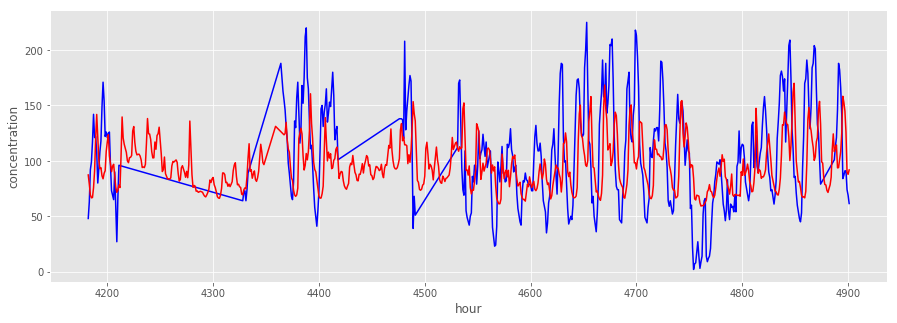

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
1974   2004-06  0.016949  0.071125  0.029790     0.187355
1975   2004-06  0.013559  0.041959  0.010156     0.116282
y_train_walk:
 1974    41.0
1975    65.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_test_walk:
 4182    63.0
4183    92.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 6s - loss: 88.8206 - val_loss: 102.4436
Epoch 2/50
 - 0s - loss: 88.6049 - val_loss: 102.1360
Epoch 3/50
 - 0s - loss: 88.2896 - val_loss: 101.6612
Epoch 4/50
 - 0s - loss: 87.8218 - val_loss: 100.9392
Epoch 5/50
 - 0s - loss: 87.1412 - val_loss: 99.8781
Epoch 6/50
 - 0s - loss: 86.1793 - val_loss: 98.3730
Epoch 7/50
 - 0s 

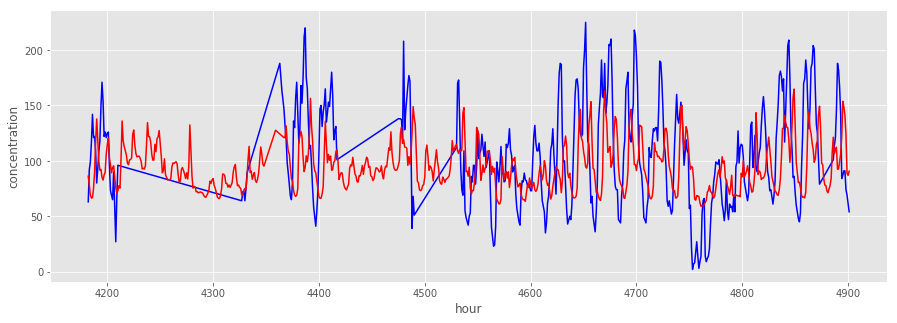

#---------------------------------------#
startYearMonth:  2004-07
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    77.0
2695    50.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    74.0
4903    69.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 6s - loss: 92.4615 - val_loss: 103.0165
Epoch 2/50
 - 0s - loss: 92.3555 - val_loss: 102.8783
Epoch 3/50
 - 0s - loss: 92.2040 - val_loss: 102.6617
Epoch 4/50
 - 0s - loss: 91.9836 - val_loss: 102.3292
Epoch 5/50
 - 0s - loss: 91.6681 - val_loss: 101.8360
Epoch 6/50
 - 0s - loss: 91.2274 - val_loss:

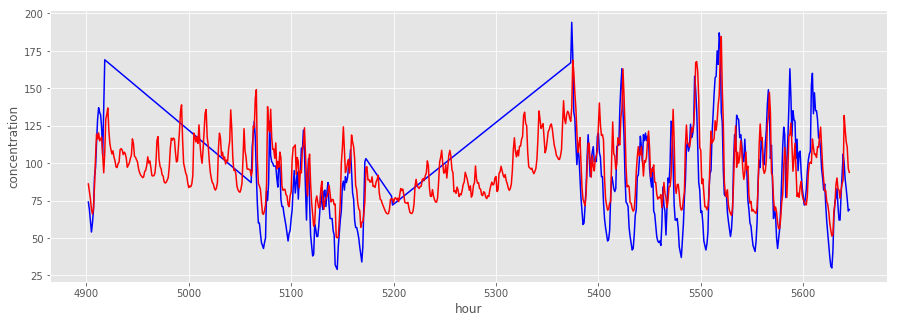

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    50.0
2695    45.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    69.0
4903    61.5
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 7s - loss: 92.4734 - val_loss: 103.0459
Epoch 2/50
 - 0s - loss: 92.4009 - val_loss: 102.9763
Epoch 3/50
 - 0s - loss: 92.3318 - val_loss: 102.9072
Epoch 4/50
 - 0s - loss: 92.2627 - val_loss: 102.8381
Epoch 5/50
 - 0s - loss: 92.1937 - val_loss: 102.7691
Epoch 6/50
 - 0s - loss: 92.1247 - val_loss: 102.7001
Epoch 7/50
 - 0

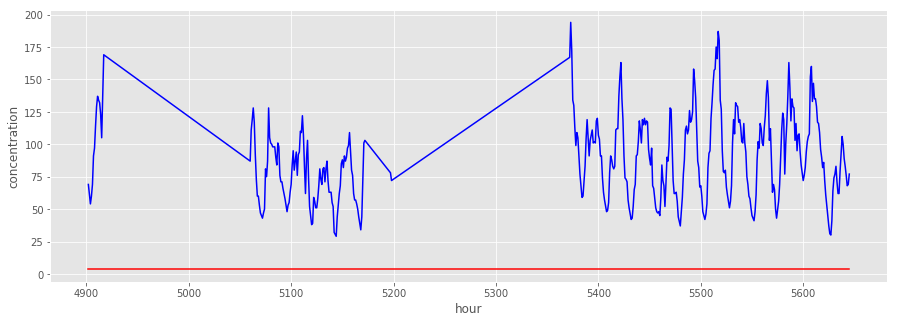

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    45.0
2695    40.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    61.5
4903    54.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 6s - loss: 92.4782 - val_loss: 103.0379
Epoch 2/50
 - 0s - loss: 92.3850 - val_loss: 102.9037
Epoch 3/50
 - 0s - loss: 92.2400 - val_loss: 102.6947
Epoch 4/50
 - 0s - loss: 92.0294 - val_loss: 102.3741
Epoch 5/50
 - 0s - loss: 91.7273 - val_loss: 101.8979
Epoch 6/50
 - 0s - loss: 91.3038 - val_loss: 101.2167
Epoch 7/50
 - 0

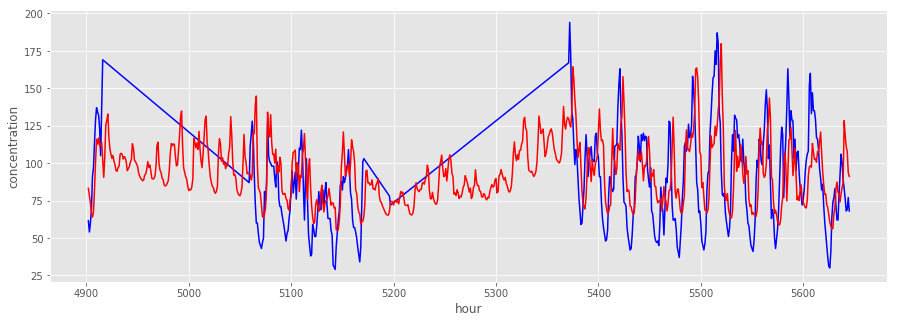

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    40.0
2695    66.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    54.0
4903    60.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 7s - loss: 92.4464 - val_loss: 102.9271
Epoch 2/50
 - 0s - loss: 92.2816 - val_loss: 102.7053
Epoch 3/50
 - 0s - loss: 92.0605 - val_loss: 102.3717
Epoch 4/50
 - 0s - loss: 91.7426 - val_loss: 101.8709
Epoch 5/50
 - 0s - loss: 91.2889 - val_loss: 101.1380
Epoch 6/50
 - 0s - loss: 90.6551 - val_loss: 100.0993
Epoch 7/50
 - 0

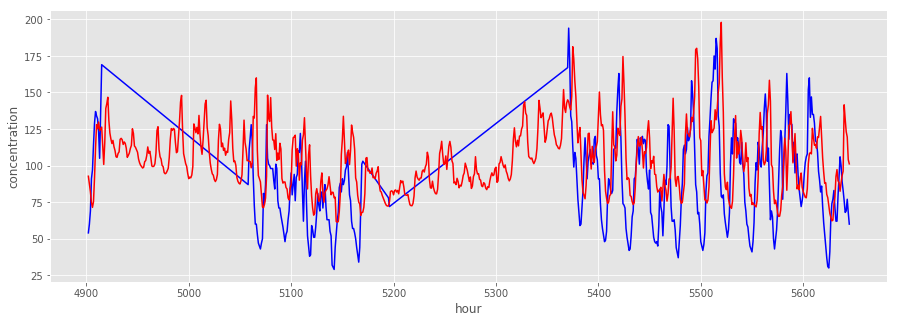

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
2694   2004-07  0.186441  0.199445  0.073798     0.410523
2695   2004-07  0.118644  0.152643  0.043331     0.318890
y_train_walk:
 2694    66.0
2695    60.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4902   2004-10  0.152542  0.160685  0.138118     0.405217
4903   2004-10  0.127119  0.149724  0.093433     0.366751
y_test_walk:
 4902    60.0
4903    69.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 744 samples
Epoch 1/50
 - 7s - loss: 92.4871 - val_loss: 103.0169
Epoch 2/50
 - 0s - loss: 92.3872 - val_loss: 102.8886
Epoch 3/50
 - 0s - loss: 92.2464 - val_loss: 102.6678
Epoch 4/50
 - 0s - loss: 92.0056 - val_loss: 102.2736
Epoch 5/50
 - 0s - loss: 91.6272 - val_loss: 101.6475
Epoch 6/50
 - 0s - loss: 91.0689 - val_loss: 100.7175
Epoch 7/50
 - 0

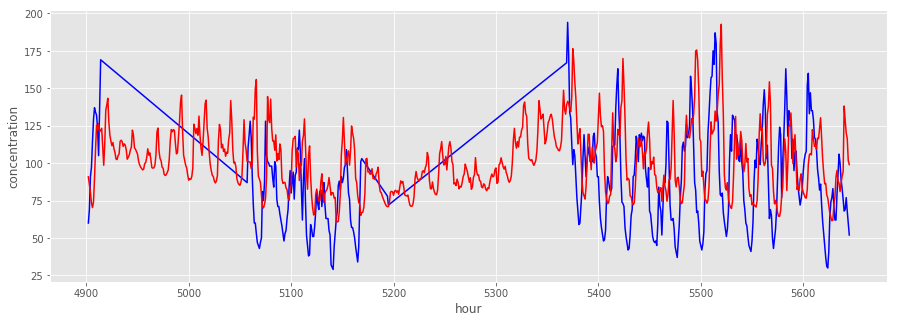

#---------------------------------------#
startYearMonth:  2004-08
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    70.0
3439    40.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    77.0
5647    68.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 8s - loss: 92.7789 - val_loss: 119.8003
Epoch 2/50
 - 0s - loss: 92.6314 - val_loss: 119.5835
Epoch 3/50
 - 0s - loss: 92.3665 - val_loss: 119.1701
Epoch 4/50
 - 0s - loss: 91.9144 - val_loss: 118.4670
Epoch 5/50
 - 0s - loss: 91.1990 - val_loss: 117.3583
Epoch 6/50
 - 0s - loss: 90.1336 - val_loss:

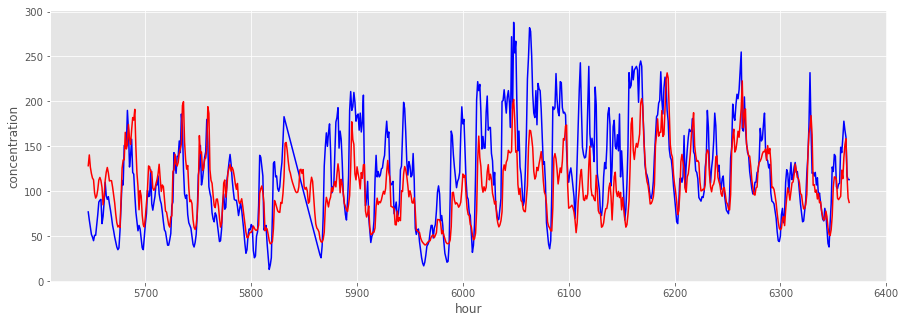

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    40.0
3439    33.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    68.0
5647    60.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 8s - loss: 92.7826 - val_loss: 119.8091
Epoch 2/50
 - 0s - loss: 92.5607 - val_loss: 119.4473
Epoch 3/50
 - 0s - loss: 92.1480 - val_loss: 118.8074
Epoch 4/50
 - 0s - loss: 91.4676 - val_loss: 117.7469
Epoch 5/50
 - 0s - loss: 90.4079 - val_loss: 116.1083
Epoch 6/50
 - 0s - loss: 88.8487 - val_loss: 113.7708
Epoch 7/50
 - 0

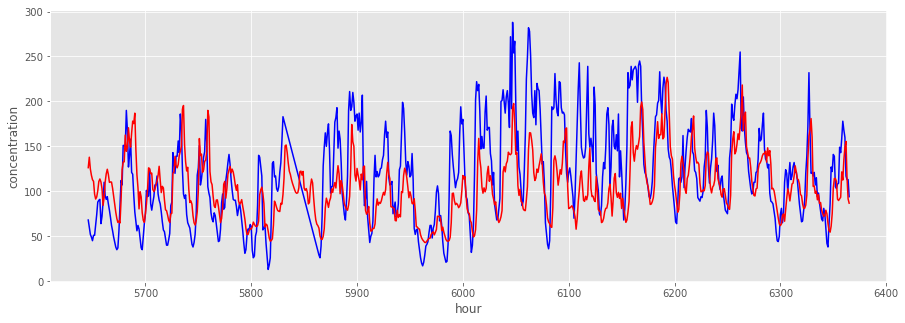

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    33.0
3439    26.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    60.0
5647    52.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 8s - loss: 92.7481 - val_loss: 119.7499
Epoch 2/50
 - 0s - loss: 92.5476 - val_loss: 119.4724
Epoch 3/50
 - 0s - loss: 92.2518 - val_loss: 119.0381
Epoch 4/50
 - 0s - loss: 91.8075 - val_loss: 118.3710
Epoch 5/50
 - 0s - loss: 91.1543 - val_loss: 117.3859
Epoch 6/50
 - 0s - loss: 90.2252 - val_loss: 116.0052
Epoch 7/50
 - 0

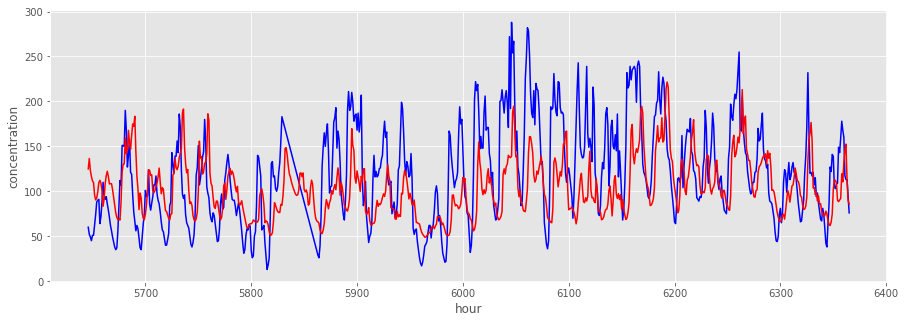

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    26.0
3439    21.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    52.0
5647    49.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 8s - loss: 92.7709 - val_loss: 119.7909
Epoch 2/50
 - 0s - loss: 92.5609 - val_loss: 119.4931
Epoch 3/50
 - 0s - loss: 92.2155 - val_loss: 118.9563
Epoch 4/50
 - 0s - loss: 91.6362 - val_loss: 118.0886
Epoch 5/50
 - 0s - loss: 90.7703 - val_loss: 116.7888
Epoch 6/50
 - 0s - loss: 89.5331 - val_loss: 114.9548
Epoch 7/50
 - 0

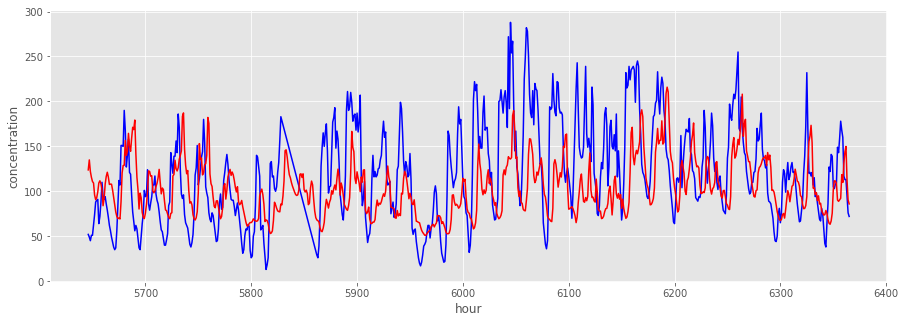

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
3438   2004-08  0.161017  0.172297  0.070413     0.364541
3439   2004-08  0.144068  0.150660  0.050779     0.348292
y_train_walk:
 3438    21.0
3439    30.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
5646   2004-11  0.262712  0.246370  0.213947     0.835083
5647   2004-11  0.305085  0.277602  0.227488     0.998453
y_test_walk:
 5646    49.0
5647    45.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (2208, 1, 4) (2208, 5)
Train on 2208 samples, validate on 720 samples
Epoch 1/50
 - 8s - loss: 92.8361 - val_loss: 119.9077
Epoch 2/50
 - 0s - loss: 92.7049 - val_loss: 119.7210
Epoch 3/50
 - 0s - loss: 92.4917 - val_loss: 119.4131
Epoch 4/50
 - 0s - loss: 92.1612 - val_loss: 118.9244
Epoch 5/50
 - 0s - loss: 91.6659 - val_loss: 118.1847
Epoch 6/50
 - 0s - loss: 90.9530 - val_loss: 117.1297
Epoch 7/50
 - 0

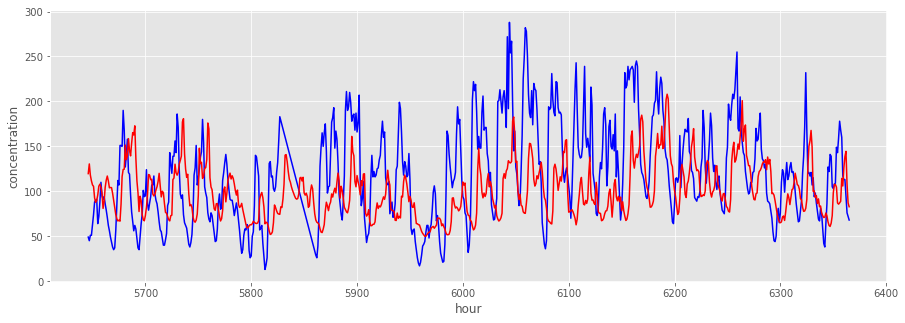

#---------------------------------------#
startYearMonth:  2004-09
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    79.0
4183    61.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    94.0
6367    76.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 9s - loss: 108.4461 - val_loss: 120.1863
Epoch 2/50
 - 0s - loss: 108.2107 - val_loss: 119.8759
Epoch 3/50
 - 0s - loss: 107.8216 - val_loss: 119.3941
Epoch 4/50
 - 0s - loss: 107.2206 - val_loss: 118.6578
Epoch 5/50
 - 0s - loss: 106.3216 - val_loss: 117.5770
Epoch 6/50
 - 0s - loss: 105.0404 - val

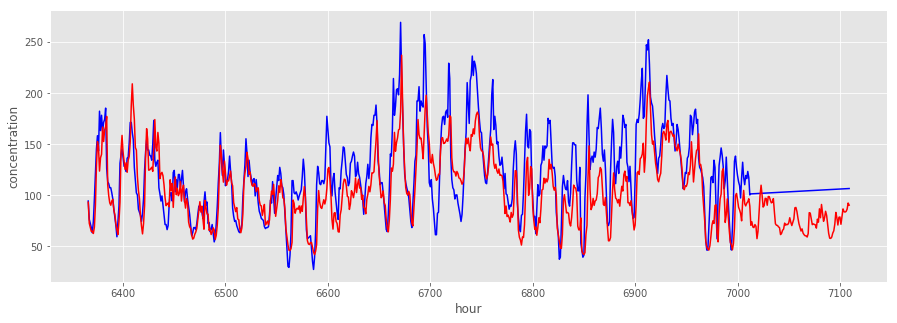

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    61.0
4183    54.5
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    76.0
6367    72.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 9s - loss: 108.4919 - val_loss: 120.2831
Epoch 2/50
 - 0s - loss: 108.3831 - val_loss: 120.1711
Epoch 3/50
 - 0s - loss: 108.2576 - val_loss: 120.0282
Epoch 4/50
 - 0s - loss: 108.0889 - val_loss: 119.8301
Epoch 5/50
 - 0s - loss: 107.8534 - val_loss: 119.5532
Epoch 6/50
 - 0s - loss: 107.5301 - val_loss: 119.1793
Epoch 7/5

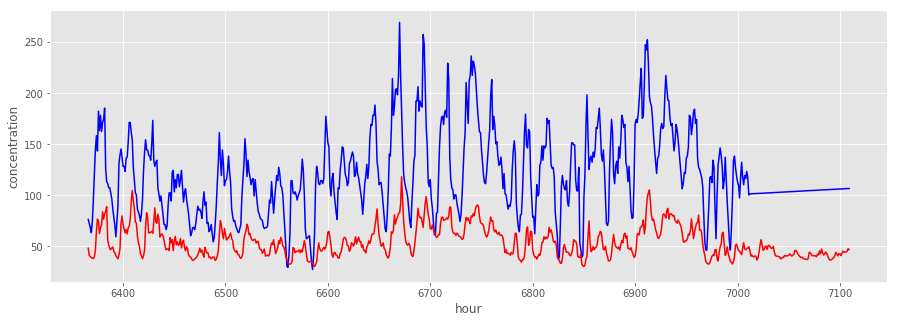

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    54.5
4183    48.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    72.0
6367    68.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 8s - loss: 108.4063 - val_loss: 120.2258
Epoch 2/50
 - 0s - loss: 108.1952 - val_loss: 119.9607
Epoch 3/50
 - 0s - loss: 107.8063 - val_loss: 119.4157
Epoch 4/50
 - 0s - loss: 107.0841 - val_loss: 118.5059
Epoch 5/50
 - 0s - loss: 105.9370 - val_loss: 117.1034
Epoch 6/50
 - 0s - loss: 104.2316 - val_loss: 115.0778
Epoch 7/5

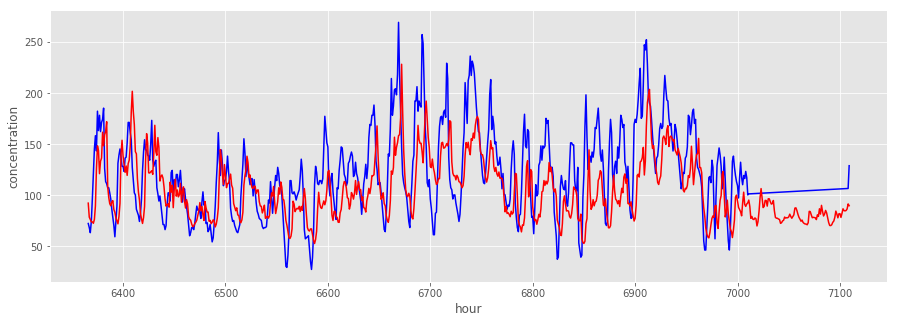

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    48.0
4183    63.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    68.0
6367    63.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 9s - loss: 108.4554 - val_loss: 120.3420
Epoch 2/50
 - 0s - loss: 108.2554 - val_loss: 120.1045
Epoch 3/50
 - 0s - loss: 107.9597 - val_loss: 119.7426
Epoch 4/50
 - 0s - loss: 107.5105 - val_loss: 119.1965
Epoch 5/50
 - 0s - loss: 106.8434 - val_loss: 118.3968
Epoch 6/50
 - 0s - loss: 105.8896 - val_loss: 117.2754
Epoch 7/5

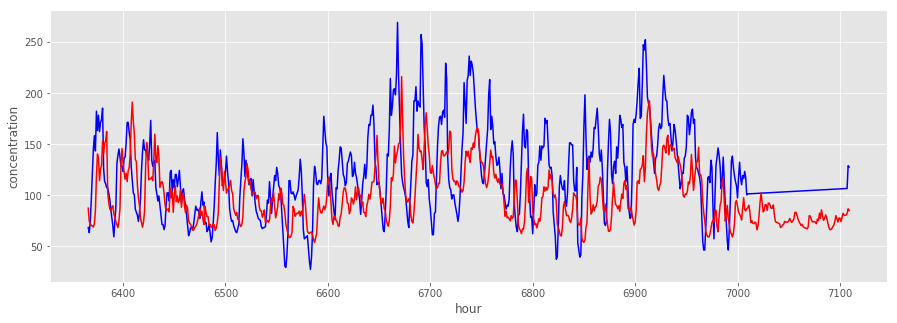

#---------------------------------------#
X_train_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
4182   2004-09  0.152542  0.146829  0.126608     0.281972
4183   2004-09  0.101695  0.107171  0.090724     0.229247
y_train_walk:
 4182    63.0
4183    92.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
      YearMonth        CO      C6H6       NOx  PT08.S5(O3)
6366   2004-12  0.177966  0.115245  0.183480     0.297115
6367   2004-12  0.101695  0.056178  0.104942     0.223057
y_test_walk:
 6366    63.0
6367    74.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (2184, 1, 4) (2184, 5)
Train on 2184 samples, validate on 744 samples
Epoch 1/50
 - 9s - loss: 108.3800 - val_loss: 120.3079
Epoch 2/50
 - 0s - loss: 108.1012 - val_loss: 119.9538
Epoch 3/50
 - 0s - loss: 107.6548 - val_loss: 119.4013
Epoch 4/50
 - 0s - loss: 106.9628 - val_loss: 118.5536
Epoch 5/50
 - 0s - loss: 105.9208 - val_loss: 117.2981
Epoch 6/50
 - 0s - loss: 104.4187 - val_loss: 115.5254
Epoch 7/5

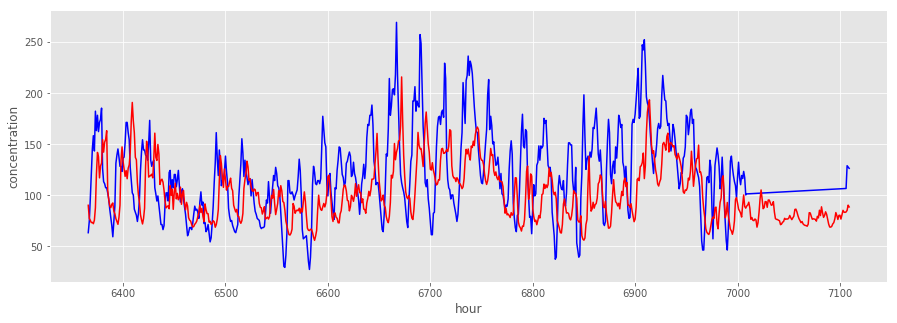

#---------------------------------------#
startYearMonth:  2004-10
[[25.46432497037251, 62.731151987838366, 40.830827223067864, 38.03565843572826, 40.67367209956067], [29.00721801991698, 41.025411238858865, 40.31917397613624, 42.869367884170266, 45.72647945249336], [22.307527786800588, 24.128269565257344, 25.254168741282058, 25.97004111742964, 26.741720285759154], [26.588921159529377, 31.793027578247653, 35.82196907951448, 39.08922022507454, 41.44980312000098], [26.76960837433632, 105.22523346529012, 31.276325043165386, 32.151958735320754, 33.795192287881356], [41.13785250199177, 46.48376044646233, 51.45848453643088, 55.167454894107664, 59.24038946715947], [29.77805437040123, 73.75251011998459, 37.35243333471366, 42.634948214801106, 43.69200086048985]]


In [26]:
def train_rnn_model(df_X, df_y, futureYList, rnnModelList, evaResList, rnn_hidden_neurons=8):    
    plt.figure(figsize=(10,5))
    
    month_shift = 3
    
    for startYearMonth in df_X.YearMonth.unique():
        print('startYearMonth: ', startYearMonth)
        if startYearMonth.month == 12 - month_shift + 1: # stopping criteria
            break 
        iterList = []
        for i, labelY in enumerate(futureYList):
            rangeTrainArr = [x for x in range(startYearMonth.month, startYearMonth.month+month_shift)]
            rangeTestArr = [startYearMonth.month+month_shift]
            rangeTrainPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTrainArr]
            rangeTestPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTestArr]   
            # segmentaion, use YearMonth as index
            X_train_walk = df_X.loc[df_X.YearMonth.isin(rangeTrainPeriodArray)].copy()
            X_test_walk = df_X.loc[df_X.YearMonth.isin(rangeTestPeriodArray)].copy()        
            y_train_walk = df_y[df_y.index.isin(X_train_walk.index)].copy()
            y_test_walk = df_y[df_y.index.isin(X_test_walk.index)].copy()
            print('X_train_walk:\n', X_train_walk.iloc[:2,:])
            print('y_train_walk:\n', y_train_walk[labelY].iloc[:2])
            print('X_test_walk:\n', X_test_walk.iloc[:2,:])
            print('y_test_walk:\n', y_test_walk[labelY].iloc[:2])
            # drop YearMonth
            X_train_walk.drop(columns=["YearMonth"], inplace=True)
            X_test_walk.drop(columns=["YearMonth"], inplace=True)       
            
            # reshape input feature to be 3 Dimension, ie. [samples, timesteps, features]
            X_train_rnn = X_train_walk.values.reshape((X_train_walk.shape[0], 1, X_train_walk.shape[1])) # np.array            
            X_test_rnn = X_test_walk.values.reshape((X_test_walk.shape[0], 1, X_test_walk.shape[1])) # np.array            
            print('df_X and df_Y shape: \n', X_train_rnn.shape, y_train_walk.shape)            
            # design network            
            model = Sequential()
            model.add(LSTM(rnn_hidden_neurons,
                           activation='relu',
                           kernel_initializer='glorot_uniform',
                           input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam')
            # fit network            
            # Set callback functions to early stop training and save the best model so far
            modelName = "rnnModel" + str(i) + ".h5"
            callbacks = [EarlyStopping(monitor='val_loss', patience=5),
                         ModelCheckpoint(filepath=modelName, monitor='val_loss', save_best_only=True)]            
            history = model.fit(X_train_rnn, y_train_walk[labelY].values, 
                                epochs=50, 
                                batch_size=32, 
                                validation_data=(X_test_rnn, y_test_walk[labelY].values), 
                                callbacks=callbacks, # Early stopping
                                verbose=2, 
                                shuffle=False)
            # predict
            y_pred = model.predict(X_test_rnn, verbose=1) # batch_size default 32            
            # eval
            print('The rmse of prediction is:', mean_squared_error(y_test_walk.iloc[:, i], y_pred) ** 0.5)             
            iterList.append(mean_squared_error(y_test_walk.iloc[:, i], y_pred) ** 0.5)
            
            # save model name                        
            if(startYearMonth.month == 3): 
                rnnModelList.append(modelName)
            # serialize weights to HDF5
            model.save_weights(modelName)
            print("Saved model" + modelName + "to disk")
            
            # plot
            plt.figure(figsize=(15,5))
            x = X_test_walk.index
            plt.subplot(1, 1, 1)
            plt.plot(x,y_test_walk.iloc[:, i],'b')            
            plt.plot(x,y_pred,'r')
            plt.xlabel('hour')
            plt.ylabel('concentration')

            plt.show()      
            print('#---------------------------------------#')            
        evaResList.append(iterList)
    plt.show()
    return evaResList
            
rnnModelList = []
evaResList = []
evaResList = train_rnn_model(X_train_norm, y_train, futureYList, rnnModelList, evaResList)
print(evaResList)

Starting predicting...

rnnModelList:  ['rnnModel0.h5', 'rnnModel1.h5', 'rnnModel2.h5', 'rnnModel3.h5', 'rnnModel4.h5']
modelName file: rnnModel0.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.173939  0.095741  0.162572     0.431353
1   2005-01  0.174419  0.201225  0.162996     0.614301
df_X and df_Y shape: 
 (2242, 1, 4) (2242, 5)
Loaded model from disk
2242/2242 [==============================] - 3s 1ms/step
The rmse of prediction is: 51.20546344760185


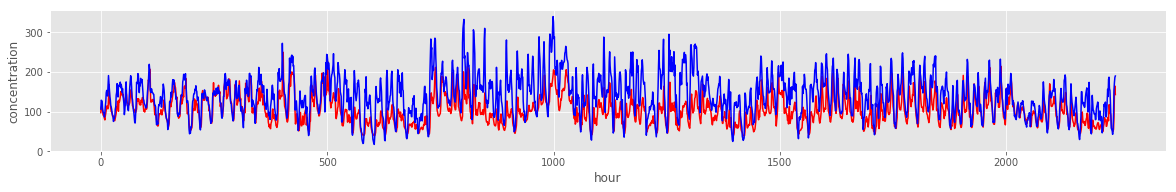

modelName file: rnnModel1.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.173939  0.095741  0.162572     0.431353
1   2005-01  0.174419  0.201225  0.162996     0.614301
df_X and df_Y shape: 
 (2242, 1, 4) (2242, 5)
Loaded model from disk
2242/2242 [==============================] - 4s 2ms/step
The rmse of prediction is: 97.34458296178747


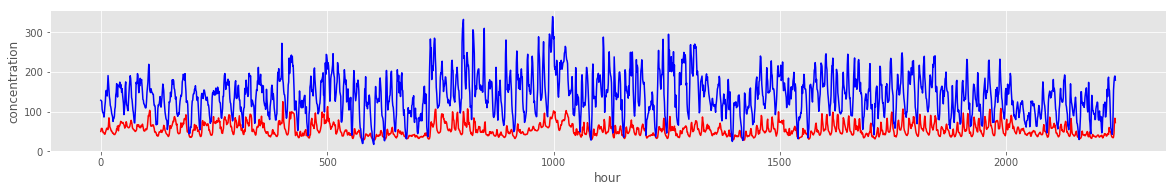

modelName file: rnnModel2.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.173939  0.095741  0.162572     0.431353
1   2005-01  0.174419  0.201225  0.162996     0.614301
df_X and df_Y shape: 
 (2242, 1, 4) (2242, 5)
Loaded model from disk
2242/2242 [==============================] - 4s 2ms/step
The rmse of prediction is: 60.176818452523854


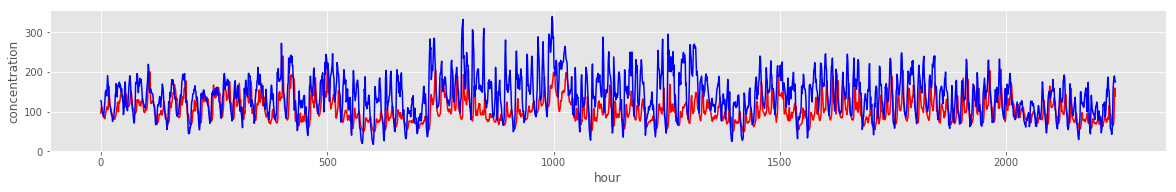

modelName file: rnnModel3.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.173939  0.095741  0.162572     0.431353
1   2005-01  0.174419  0.201225  0.162996     0.614301
df_X and df_Y shape: 
 (2242, 1, 4) (2242, 5)
Loaded model from disk
2242/2242 [==============================] - 4s 2ms/step
The rmse of prediction is: 66.42156620003665


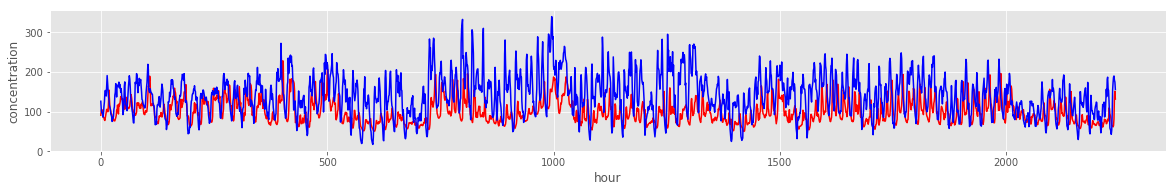

modelName file: rnnModel4.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.173939  0.095741  0.162572     0.431353
1   2005-01  0.174419  0.201225  0.162996     0.614301
df_X and df_Y shape: 
 (2242, 1, 4) (2242, 5)
Loaded model from disk
2242/2242 [==============================] - 4s 2ms/step
The rmse of prediction is: 67.01234794687811


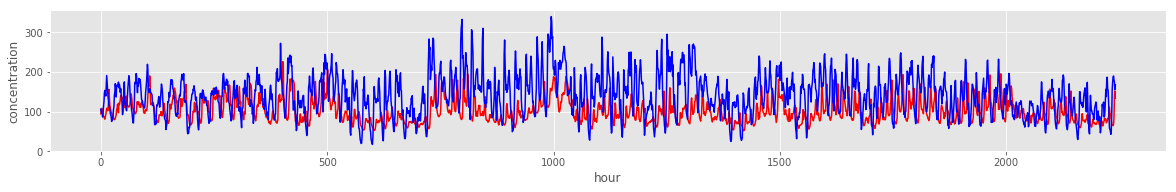

In [27]:
print('Starting predicting...\n')

# model predict and show result seperately
def validation_rnn_model(df_X, df_y, rnnModelList, rnn_hidden_neurons=8):
    print('rnnModelList: ', rnnModelList)
    
    for i, modelName in enumerate(rnnModelList):
        print('modelName file: {}'.format(modelName))
        # drop YearMonth
        X_valid = df_X.drop(columns=["YearMonth"])
        print(df_X.iloc[:2,:])        
        # reshape input feature to be 3 Dimension, ie. [samples, timesteps, features]
        X_valid_rnn = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1])) # np.array                    
        print('df_X and df_Y shape: \n', X_valid_rnn.shape, df_y.shape)                    
        
        # call model
        model = Sequential()
        model.add(LSTM(rnn_hidden_neurons, 
                        activation='relu', 
                        kernel_initializer='glorot_uniform',
                        input_shape=(X_valid_rnn.shape[1], X_valid_rnn.shape[2])))        
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        # load weights after compile
        model.load_weights(modelName)
        print("Loaded model from disk")                
        
        # predict
        y_pred = model.predict(X_valid_rnn, verbose=1) # batch_size default 32

        # eval
        print('The rmse of prediction is:', mean_squared_error(df_y.iloc[:, i], y_pred) ** 0.5)    
        # plot
        plt.figure(figsize=(20,15))            
        x = X_valid.index
        plt.subplot(len(lgbmModelList), 1, i+1)
        plt.plot(x,y_pred,'r')
        plt.plot(x,y_valid.iloc[:, i],'b')
        plt.xlabel('hour')
        plt.ylabel('concentration')

        plt.show()
    return y_pred
        
y_pred = validation_rnn_model(X_valid_norm, y_valid, rnnModelList)   

### Prediction Air Quality Index
* predict hourly -> calculate daily mean

### Air Quality Category Table
|Air Quality Category| CO(ppm) 8小時平均值|
|---|---|
|Good / 良好| 0 ~ 53|
|Moderate / 普通| 54 ~ 100|
|Unhealthy for Sensitive Groups / 對敏感族群不健康| 101 ~ 360|
|Unhealthy / 對所有族群不健康| 361 ~ 649|
|Very Unhealthy / 非常不健康|650~ 1249|
|Hazardous / 危害| > 1250|

* Reference
    * [行政院環保署 空氣品質監測網](https://taqm.epa.gov.tw/taqm/tw/b0201.aspx)

In [35]:
df_date = pd.DataFrame(X_valid["DateTime"])
df_date["DateTime"] = pd.to_datetime(X_valid['DateTime'], format='%Y-%m-%d %H:%M:%S')
print(df_date.shape)
df_date.head(2)

(2242, 1)


DateTime
0 2005-01-01 00:00:00
1 2005-01-01 01:00:00

In [36]:
df_y_pred = pd.DataFrame(y_pred, columns=["y_pred"])
print(df_y_pred.shape)
df_y_pred.head(2)

(2242, 1)


y_pred
0   94.172142
1  106.969109

In [37]:
df_ans = pd.concat([df_date, df_y_pred], axis=1)
df_ans = df_ans.set_index(["DateTime"])
df_ans.head(2)

y_pred
DateTime                       
2005-01-01 00:00:00   94.172142
2005-01-01 01:00:00  106.969109

In [38]:
# hourly to daily value
df_ans = df_ans.groupby(df_ans.index.date).mean()
df_ans.head(5)

y_pred
2005-01-01  103.472969
2005-01-02  105.144485
2005-01-03  123.006805
2005-01-04  111.173164
2005-01-05  125.622818

In [39]:
print(df_ans.iloc[:5, :])

                y_pred
2005-01-01  103.472969
2005-01-02  105.144485
2005-01-03  123.006805
2005-01-04  111.173164
2005-01-05  125.622818


### Cautioun!
I should train 24 * 5 models. But due to CPU power and mem capacity, I just train 5 models for simplicity.

In [40]:
# predict the next 5 days we want.
# max 3000 is just for convenience :P
df_ans["Air Quality Category"] = pd.cut(df_ans["y_pred"], [0, 54, 101, 361, 650, 1250, 3000], labels=["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"])
df_ans.head(5)

y_pred            Air Quality Category
2005-01-01  103.472969  Unhealthy for Sensitive Groups
2005-01-02  105.144485  Unhealthy for Sensitive Groups
2005-01-03  123.006805  Unhealthy for Sensitive Groups
2005-01-04  111.173164  Unhealthy for Sensitive Groups
2005-01-05  125.622818  Unhealthy for Sensitive Groups